In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.ticker
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from shapely.geometry import Point

import statistics
import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [2]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

In [89]:
def build_training_set(network, target_column):
    # explode the dataset to include all node pairs
    node_ids = network.nodes.index.values
    origins = pd.DataFrame(node_ids, columns = ['origin'])
    destinations = pd.DataFrame(node_ids, columns = ['destination'])
    cartesian_product = origins.merge(destinations, how='cross')
    
    # compute distnace between all pairs
    centroid = network.nodes.centroid
    centroid_long = centroid.x
    centroid_long.name = 'long'
    centroid_lat = centroid.y
    centroid_lat.name = 'lat'
    centroids = pd.concat([centroid_long, centroid_lat], axis=1)
    centroid_from = cartesian_product.join(centroids, on=network._origin).rename(columns={'long': 'long_from', 'lat': 'lat_from'})
    centroid_all = centroid_from.join(centroids, on=network._destination).rename(columns={'long': 'long_to', 'lat': 'lat_to'})
    from_points = list(zip(centroid_all.lat_from, centroid_all.long_from))
    to_points = list(zip(centroid_all.lat_to, centroid_all.long_to))
    centroid_all['distance'] = haversine_vector(from_points, to_points, Unit.KILOMETERS)
    centroid_all.drop(['long_from', 'lat_from', 'long_to', 'lat_to'], axis=1, inplace=True)
#     print(centroid_all.columns)
    centroid_above = centroid_all.loc[centroid_all.distance > 0]
    centroid_below = centroid_all.loc[centroid_all.distance == 0]
    del centroid_below['distance']
    misDistance = centroid_above.groupby(['origin']).agg({'distance':min})
    misDistance['distance'] = misDistance['distance']
    centroid_below = centroid_below.merge(misDistance,on=['origin'])
#     centroid_all.loc[centroid_all.distance == 0, 'distance'] = centroid_all.loc[centroid_all.distance > 0, 'distance'].min()*0.5
    centroid_all = pd.concat([centroid_above,centroid_below],axis=0)
    # compute jobs and residence
    comp_aggs={target_column: 'sum'}
    jobs = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
    residence = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
    features = centroid_all.join(residence, on='origin').join(jobs, on='destination')
    
    # merge flow data
    flow = network.edges.rename(columns={target_column: 'flow'})[['origin', 'destination', 'flow']]
    combined = features.merge(flow, how='left', on=['origin', 'destination']).fillna(0)
    
    return combined

In [91]:
# change here to age groups
target_columns = ['S000','SE01','SE03']
for city, state, conties in cities:
    
    print(city)
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    for target_column in target_columns:
        training_set = build_training_set(city_network, target_column)
        training_set.to_parquet(f'data/{target_column}_{city}.parquet',index=False)

New York City
Los Angeles
Chicago
Houston
Boston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin


In [100]:
for city, state, conties in cities:
    df0 = pd.read_parquet(f'data/S000_{city}.parquet')
    print(df0.shape)

(4652649, 6)
(5480281, 6)
(1737124, 6)
(617796, 6)
(270400, 6)
(839056, 6)
(147456, 6)
(133956, 6)
(393129, 6)
(279841, 6)
(138384, 6)
(47524, 6)


In [92]:
for city, state, conties in cities:
    df0 = pd.read_parquet(f'data/S000_{city}.parquet')
    df1 = pd.read_parquet(f'data/SE01_{city}.parquet')
    df3 = pd.read_parquet(f'data/SE03_{city}.parquet')
    df0.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
    df1.rename(columns={'jobs':'SE01jobs', 'residence':'SE01residence','flow':'SE01flow'}, inplace=True)
    df3.rename(columns={'jobs':'SE03jobs', 'residence':'SE03residence','flow':'SE03flow'}, inplace=True)
    merged = df0.merge(df1,on=['origin','destination'],how='outer').merge(df3,on=['origin','destination'],how='outer')
    merged.to_parquet(f'data/income_{city}.parquet', index=False)

# baseline

### unconstrain model, power law

In [3]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def baseline_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_predict(test,target,pars):
    test[target+'k'] = pars[0]
    test[target+'a'] = pars[1]
    test[target+'pred'] = test[target+'k']*(test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test

## f(d)

In [4]:
def unconstrained_bucked_constant_kfit(data, target):
    binf = {}
    X = data[target+'jobs'].values*data[target+'residence'].values
    y = data[target+'flow'].values
    model = sm.OLS(y,X)
    results = model.fit()
    k = results.params[0]
    data[target+'k'] = k
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = (results.params[0],subData['distance'].median())
    return (binf,k)
def unconstrained_bucked_constant_kpredict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x][0])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

## linear f(d)

In [5]:
def unconstrained_bucked_linear_kpredict(test,target,k,binf):
    
    # linear interpolation to get f(d) value for each distance value
    # backfill to fill values for values in the fisrt and last half bins
    binfdf_interpolation = pd.DataFrame(binf).T
    binfdf_interpolation.columns = ['f(d)','distance']
    binfdf_interpolation['bin'] = binf.keys()
    binfdf_interpolation =  pd.concat([test[['distance']].drop_duplicates(),
                                       binfdf_interpolation]).sort_values(by='distance')
    binfdf_interpolation = binfdf_interpolation.set_index('distance')
    binfdf_interpolation['f(d)inter'] = binfdf_interpolation['f(d)'].interpolate(method='index')
    binfdf_interpolation = binfdf_interpolation.reset_index()
    binfdf_interpolation['f(d)inter'] = binfdf_interpolation['f(d)inter'].fillna(method='backfill')
    binfdf_interpolation = binfdf_interpolation[['distance','f(d)inter']]
    binfdf_interpolation.columns = ['distance',target+'_f(d)inter']
    
    test = test.merge(binfdf_interpolation,on='distance',how='left')
    test[target+'k'] = k
#     test[target+'f'] = test['bin'].apply(lambda x:binf[x][0])
    test[target+'pred'] = test[target+'k']*test[target+'_f(d)inter']*test[target+'jobs']*test[target+'residence']
    return test

In [6]:
def locBin(x,distBin):
    if x >= distBin[0] and x <= distBin[-1]:
        for i,num in enumerate(distBin):
            if x >= distBin[i] and x<= distBin[i+1]:
                return i
    else:
        raise Exception(f'Can not find bin for {x}')

# start point

In [6]:
citiesList = ['New York City','Los Angeles','Chicago','Houston',
          'Boston','Phoenix','Philadelphia','San Antonio','San Diego', 'Dallas', 'San Jose', 'Austin']
points = [0.480595,1.118437,1.02187,1.809567,1.662374,1.837157,0.731242,2.082544,1.99236, 1.540729, 1.480432, 2.497922]
startPoints = dict(zip(citiesList, points))

## find optimal bin

#### determined to use 40 bins from the figure above

In [8]:
# expand bin to include the nearest datapoints
def mergeBin(df,rate,number):
    df = df.sort_values(by=['distance']).reset_index(drop=True)
    pad = pd.DataFrame()
    thre = max(int(rate*len(df)),number)

    for binNo in df.bin.unique():
        # not enough datapoints in a bin
        if len(df.loc[df['bin']==binNo]) < thre:
            # index of current bin
            indexes = df.loc[df['bin']==binNo].index.values.astype(int)
            # how many datapoints are needed from other bins
            addedVolume = thre - len(df.loc[df['bin']==binNo])
            
            # do we have enough datapoints on the left side
            if indexes[0] > int(addedVolume/2):
                # left side
                padTemp = df.iloc[indexes[0] - int(addedVolume/2): indexes[0]]
                                            # right side
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]:indexes[-1] + int(addedVolume/2)]])
                padTemp['bin'] = binNo
#                 print(indexes[0] - int(addedVolume/2), indexes[0],indexes[-1],indexes[-1] + int(addedVolume/2), binNo)
            else:
                padTemp = df.iloc[:indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]: addedVolume+indexes[-1]]])
                padTemp['bin'] = binNo
#                 print(indexes[0],indexes[-1], addedVolume-indexes[0]+indexes[-1],binNo)
            pad = pd.concat([pad,padTemp])
    df = pd.concat([df,pad])
    return df

In [57]:
# 5-fold 
resultslfd40is = {}
resultsBaselineis = {}
rate, number = 0.005,2000

for bins in np.linspace(10,50,9):
    print(bins)
    bins = int(bins)
    resultslfd40is[bins] = {}
    resultslfd40os[bins] = {}
    resultsBaselineis[bins] = {}
    resultsBaselineos[bins] = {}
    for city,state, counties in cities:
        if city in citieeList:
            print(city)
            df = pd.read_parquet(f'data/income_{city}.parquet')
            df['distance'] = df['distance']/1.6
            startpoint = startPoints[city]/1.6
            # include 95% of distance 
            startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
            afterendpointPercentage = 0.05 - startpointPercentage
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
            df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
            df['logDist'] = np.log(df['distance'])
     
            
            distBin = np.linspace(np.log(startpoint),np.log(endPoint),bins+1)
            df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
            df = mergeBin(df,rate,number)

            skf = StratifiedKFold(n_splits=5)
            skf.get_n_splits(df.drop(columns='bin',axis=1), df['bin'])
                # fd
            for target in ['S000']:
                print(target)

                fdmseis = 0
                fdmseos = 0
                lfdmseis = 0
                lfdmseos = 0
                blmseis = 0
                blmseos = 0
                for train_index, test_index in skf.split(df.drop(columns='bin',axis=1), df['bin']):
                    traindf, testdf = df.iloc[train_index], df.iloc[test_index]
                    binf,k = unconstrained_bucked_constant_kfit(traindf, target)

                    # linear interpolated f(d), include distance in formulation
                    df_lfdis = unconstrained_bucked_linear_kpredict(traindf,target,k,binf)
                    df_lfdos = unconstrained_bucked_linear_kpredict(testdf,target,k,binf)

                    lfdmseis += mean_squared_error(df_lfdis[target+'flow'],df_lfdis[target+'pred'])
                    lfdmseos += mean_squared_error(df_lfdos[target+'flow'],df_lfdos[target+'pred'])


                # baseline 
                    pars = baseline_fit(traindf,target)
                    df_baselineis = baseline_predict(traindf,target,pars)
                    df_baselineos = baseline_predict(testdf,target,pars)
                    blmseis += mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])
                    blmseos += mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])


                resultslfd40is[bins][city] = resultslfd40is.get(city,[])+ [lfdmseis/5]
                resultslfd40os[bins][city] = resultslfd40os.get(city,[])+ [lfdmseos/5]

                resultsBaselineis[bins][city] = resultsBaselineis.get(city,[]) + [blmseis/5]
                resultsBaselineos[bins][city] = resultsBaselineos.get(city,[]) + [blmseos/5]

10.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
Dallas
S000
San Jose
S000
Austin
S000
15.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
Dallas
S000
San Jose
S000
Austin
S000
20.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
Dallas
S000
San Jose
S000
Austin
S000
25.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
Dallas
S000
San Jose
S000
Austin
S000
30.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
Dallas
S000
San Jose
S000
Austin
S000
35.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadel

In [58]:
resultsdf = pd.DataFrame()
for bins in resultsBaselineos.keys():
    temp = pd.DataFrame(resultslfd40os[bins])
    temp.columns =  citieeList
    temp['bins'] = bins
    resultsdf = pd.concat([resultsdf,temp])

blresultsdf = pd.DataFrame()
for bins in resultsBaselineos.keys():
    temp = pd.DataFrame(resultsBaselineos[bins])
    temp.columns =  citieeList
    temp['bins'] = bins
    blresultsdf = pd.concat([blresultsdf,temp])

In [59]:
citiBin = {}
for city in citieeList:
    index = np.argmin((resultsdf[city] - blresultsdf[city]).values)
    citiBin[city] = resultsdf['bins'].values[index]
citiBin

{'New York City': 20,
 'Los Angeles': 50,
 'Chicago': 40,
 'Houston': 40,
 'Boston': 15,
 'Phoenix': 45,
 'Philadelphia': 35,
 'San Antonio': 15,
 'San Diego': 45,
 'Dallas': 30,
 'San Jose': 15,
 'Austin': 15}

In [82]:
for city in citiBin.keys():
    fdmse = resultsdf.loc[resultsdf['bins']==citiBin[city]][city].values[0]
    blmse = blresultsdf.loc[blresultsdf['bins']==citiBin[city]][city].values[0]
    print(city,'bins:',citiBin[city],', f(d) MSE:',round(fdmse,2),'baseline MSE:',round(blmse,2) )

New York City bins: 50 , f(d) MSE: 7.24 baseline MSE: 7.26
Los Angeles bins: 40 , f(d) MSE: 6.92 baseline MSE: 6.99
Chicago bins: 35 , f(d) MSE: 15.95 baseline MSE: 16.9
Houston bins: 30 , f(d) MSE: 39.63 baseline MSE: 40.0
Boston bins: 15 , f(d) MSE: 44.65 baseline MSE: 45.02
Phoenix bins: 50 , f(d) MSE: 17.67 baseline MSE: 17.82
Philadelphia bins: 35 , f(d) MSE: 43.43 baseline MSE: 44.37
San Antonio bins: 15 , f(d) MSE: 43.58 baseline MSE: 43.63
San Diego bins: 45 , f(d) MSE: 49.16 baseline MSE: 51.28


# train on the whole dataset to get curves


In [9]:
citiBin = {'New York City': 20,
 'Los Angeles': 50,
 'Chicago': 40,
 'Houston': 40,
 'Boston': 15,
 'Phoenix': 45,
 'Philadelphia': 35,
 'San Antonio': 15,
 'San Diego': 45,
 'Dallas': 30,
 'San Jose': 15,
 'Austin': 15}

In [72]:
df = pd.read_parquet(f'data/income_{city}.parquet')
df

,origin,destination,distance_x,S000residence,S000jobs,S000flow,distance_y,SE01residence,SE01jobs,SE01flow,distance,SE03residence,SE03jobs,SE03flow
0,48453000402,48453001912,11.122912,1585,4545.0,5.0,11.122912,275,322.0,0.0,11.122912,844,3568.0,4.0
1,48453000402,48453001916,15.845681,1585,1083.0,3.0,15.845681,275,200.0,0.0,15.845681,844,585.0,0.0
2,48453000402,48453001783,15.750058,1585,459.0,2.0,15.750058,275,94.0,0.0,15.750058,844,227.0,2.0
3,48453000402,48453001918,9.294831,1585,4371.0,8.0,9.294831,275,752.0,1.0,9.294831,844,2499.0,7.0
4,48453000402,48453001784,20.602694,1585,1702.0,1.0,20.602694,275,396.0,0.0,20.602694,844,842.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47519,48453002424,48453002424,1.538283,1508,558.0,14.0,1.538283,298,130.0,2.0,1.538283,668,231.0,8.0
47520,48453001742,48453001742,2.830620,2267,1417.0,153.0,2.830620,340,311.0,28.0,2.830620,1383,691.0,65.0
47521,48453001760,48453001760,4.107266,5101,3080.0,614.0,4.107266,782,569.0,235.0,4.107266,3594,1912.0,271.0
47522,48453001826,48453001826,1.296967,867,1233.0,20.0,1.296967,169,239.0,0.0,1.296967,460,496.0,9.0


In [13]:
bindffDict = {}
Distfd1 = {}
Distfd3 = {}
Distfd0 = {}

rate = 0.005
number = 2000


for city,state, counties in cities:
    if city in citieeList:
        print(city)
        df = pd.read_parquet(f'data/income_{city}.parquet')
        df['distance'] = df['distance']/1.6
        startpoint = startPoints[city]/1.6
        # include 95% of distance 
        startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
        afterendpointPercentage = 0.05 - startpointPercentage
        if afterendpointPercentage > 0:
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
        else:
            endPoint = df.distance.max()
        print(startpoint,endPoint)
        df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
        df['logDist'] = np.log(df['distance'])
        distBin = np.linspace(np.log(startpoint),np.log(endPoint),citiBin[city]+1)
        df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
        df = mergeBin(df,rate,number)
        # fd
        for target in ['SE01','SE03','S000']:
            binf,k = unconstrained_bucked_constant_kfit(df, target)
            print(target)
            df_fdis = unconstrained_bucked_linear_kpredict(df,target,k,binf)
            binfOrigin = df_fdis[['bin',target+'_f(d)inter']].drop_duplicates()
            bindDict = dict(zip(binfOrigin['bin'],binfOrigin[target+'_f(d)inter']))
#             print(bindDict)
            bindffDict[city] = bindffDict.get(city,[]) + [bindDict]
    
        income1 = bindffDict[city][0]
        income3 = bindffDict[city][1]
        income0 = bindffDict[city][2]
        distList = []
        fdList = []
        for bins in income1.keys():

            dist = df.loc[df['bin']==bins]['distance'].mean()
            fd = income1[bins]
            distList += [dist]
            fdList += [fd]
            fdDict = dict(zip(distList,fdList))
            Distfd1[city] = dict(sorted(fdDict.items()))
        distList = []
        fdList = []
        for bins in income3.keys():
            dist = df.loc[df['bin']==bins]['distance'].mean()
            fd = income3[bins]
            distList += [dist]
            fdList += [fd]
            fdDict = dict(zip(distList,fdList))
            Distfd3[city] = dict(sorted(fdDict.items()))


New York City
0.30037187499999995 18.56300589107707
SE01
SE03
S000
Los Angeles
0.6990231249999999 43.7271445959324
SE01
SE03
S000
Chicago
0.63866875 31.888847633576454
SE01
SE03
S000
Houston
1.130979375 34.776802575823154
SE01
SE03
S000
Boston
1.0389837499999999 29.004462126670933
SE01
SE03
S000
Phoenix
1.148223125 40.905826924273455
SE01
SE03
S000
Philadelphia
0.45702624999999997 13.511822569033606
SE01
SE03
S000
San Antonio
1.3015899999999998 23.324006206879567
SE01
SE03
S000
San Diego
1.2452249999999998 41.822104264910095
SE01
SE03
S000
Dallas
0.962955625 24.43782375642617
SE01
SE03
S000
San Jose
0.9252699999999999 28.273377353442097
SE01
SE03
S000
Austin
1.5612012499999999 23.157621493544717
SE01
SE03
S000


In [18]:
import json

# create json object from dictionary
jsons = json.dumps(Distfd1)

# open file for writing, "w" 
f = open("Distfd1.json","w")

# write json object to file
f.write(jsons)

# close file
f.close()

jsons = json.dumps(Distfd3)

# open file for writing, "w" 
f = open("Distfd3.json","w")

# write json object to file
f.write(jsons)

# close file
f.close()

## Plot income-level f(d) curves

In [3]:
import json

f = open('Distfd1.json')
Distfd1 = json.load(f)

f = open('Distfd3.json')
Distfd3 = json.load(f)

citiesList = ['New York City','Los Angeles','Chicago','Houston',
          'Boston','Phoenix','Philadelphia','San Antonio','San Diego', 'Dallas', 'San Jose', 'Austin']
points = [0.480595,1.118437,1.02187,1.809567,1.662374,1.837157,0.731242,2.082544,1.99236, 1.540729, 1.480432, 2.497922]
startPoints = dict(zip(citiesList, points))

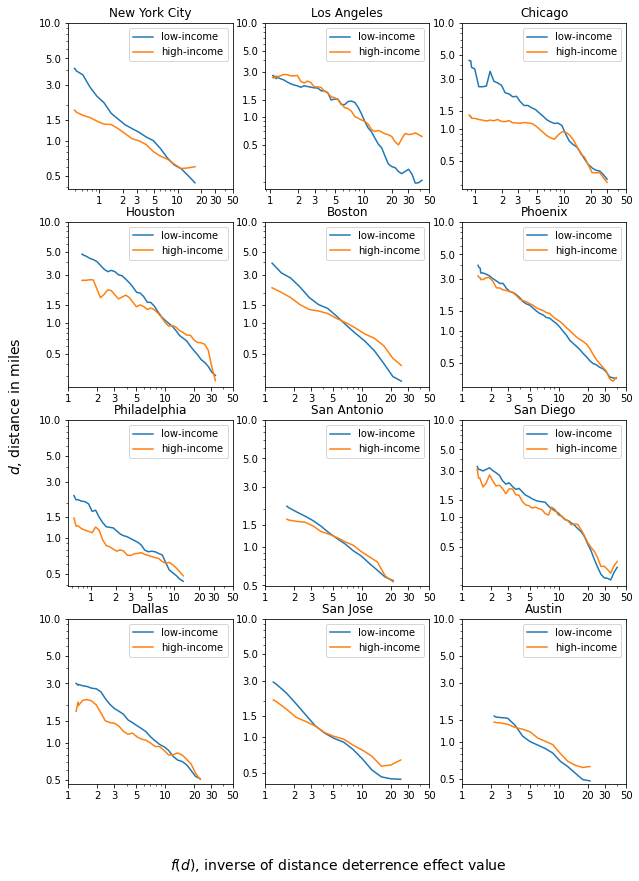

In [4]:
fig,ax = plt.subplots(4,3,figsize=(10,14))
i= 0
for city,state, counties in cities:
    if city in citiesList:
        ax[i//3,i%3].plot([float(i) for i in Distfd1[city].keys()],Distfd1[city].values(),label='low-income')
        ax[i//3,i%3].plot([float(i) for i in Distfd3[city].keys()],Distfd3[city].values(),label='high-income')
        ax[i//3,i%3].set_title(city)
        ax[i//3,i%3].legend()
        ax[i//3,i%3].set_yscale('log')
        ax[i//3,i%3].set_xscale('log')
        ax[i//3,i%3].set_yticks([0.5, 1, 1.5, 3, 5, 10])
        ax[i//3,i%3].set_xticks([1, 2, 3, 5, 10, 20, 30, 50])
        ax[i//3,i%3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax[i//3,i%3].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#         ax[i//3,i%3].set_ylabel('$f(d)$, distance deterrence effect value',fontsize=12)
#         ax[i//3,i%3].set_xlabel('$d$, distance in miles',fontsize=12)
        i += 1
        
fig.text(0.5, 0.04, '$f(d)$, inverse of distance deterrence effect value',fontsize=14, ha='center')
fig.text(0.04, 0.5, '$d$, distance in miles',fontsize=14, va='center', rotation='vertical')

plt.savefig('img/curve.png',dpi=300)

### privilege zone

In [147]:
def intersection_point(curve1,curve3):
    '''find intersection point for each bin,
    list point is all intersection points x values,
    section is the intersection lies in which bin'''  
    point = []
    section = []
    for p in range(len(curve1)):
        if p < len(curve1)-1:
            '''x1,x2 are start and end points of a distance bin'''
            x1,x2,y1,y2,z1,z2 = curve1[p][0],curve1[p+1][0],curve1[p][1],curve1[p+1][1],curve3[p][1],curve3[p+1][1]
            k1 = (y2-y1)/(x2-x1)
            b1 = y1 - k1*x1
            k3 = (z2-z1)/(x2-x1)
            b3 = z1 - k3*x1
            
            if k1 != k3:
                x_intersect = (b3-b1)/(k1-k3)
                if x_intersect > x1 and x_intersect < x2:
                    point += [x_intersect]
                    section += [p]
    return (point,section)

def the_longest_privilege_zone(curve1,curve3):
    point,section = intersection_point(curve1,curve3)
    '''find the longest priviledge zone'''
    if len(point)==1:
        # only one intersetion
        length = curve1[-1][0] - point[0]
        privilege_zone = (point[0],curve1[-1][0])
    
    else:
        length = 0
        privilege_zone = (0,0)
        for i,x in enumerate(point):
            # x is x value of intersection
            if i < len(point)-1: 
                '''section[i]+1: the intersection lies in bin i , so from the start point of bin i+1 
                to the start point of next bin has intersection (section[i+1]), 
                all SE03 values should be higher than SE01 values to be considered as a priviledge zone'''
                curve3Values = np.array(curve3)[section[i]+1:section[i+1],1]
                curve1Values = np.array(curve1)[section[i]+1:section[i+1],1]
                if all(curve3Values-curve1Values>0):
                    if point[i+1] - x > length:
                        length = point[i+1] - x
                        # point[i+1] is the next intersection's x value
                        privilege_zone = (x, point[i+1])
            else:
                '''validate the last intersection point to the end of the curve'''
                curve3Values = np.array(curve3)[section[i]+1:-1,1]
                curve1Values = np.array(curve1)[section[i]+1:-1,1]
                if all(curve3Values-curve1Values>0):
                    if curve3[-1][0] - x > length:
                        length = curve3[-1][0] - x
                        privilege_zone = (x, curve3[-1][0])
    return(length, privilege_zone)

def all_privilege_zone(curve1,curve3):
    point,section = intersection_point(curve1,curve3)
    '''find the all priviledge zones'''
    if len(point)==1:
        # only one intersetion
        length = curve1[-1][0] - point[0]
        privilege_zone = [(point[0],curve1[-1][0])]
    
    else:
        length = 0
        privilege_zone = []
        for i,x in enumerate(point):
            # x is x value of intersection
            if i < len(point)-1: 
                '''section[i]+1: the intersection lies in bin i , so from the start point of bin i+1 
                to the start point of next bin has intersection (section[i+1]), 
                all SE03 values should be higher than SE01 values to be considered as a priviledge zone'''
                curve3Values = np.array(curve3)[section[i]+1:section[i+1],1]
                curve1Values = np.array(curve1)[section[i]+1:section[i+1],1]
                if all(curve3Values-curve1Values>0):
                    # point[i+1] is the next intersection's x value
                    privilege_zone += [(x, point[i+1])]
            else:
                '''validate the last intersection point to the end of the curve'''
                curve3Values = np.array(curve3)[section[i]+1:-1,1]
                curve1Values = np.array(curve1)[section[i]+1:-1,1]
                if all(curve3Values-curve1Values>0):

                    privilege_zone += [(x, curve3[-1][0])]
    return privilege_zone

In [144]:
privilegeCommutersRate = {}
privilegeZoneLength = {}
for city,state, counties in cities:
    if city in citiesList:
        print(city)
        curve1 = list(zip([float(i) for i in Distfd1[city].keys()],Distfd1[city].values()))
        curve3 = list(zip([float(i) for i in Distfd3[city].keys()],Distfd3[city].values()))
        length,privilege_zone = the_longest_privilege_zone(curve1,curve3)
        df = pd.read_parquet(f'data/income_{city}.parquet')
        df['distance'] = df['distance']/1.6
        startpoint = startPoints[city]/1.6
        # include 95% of distance 
        startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
        afterendpointPercentage = 0.05 - startpointPercentage
        if afterendpointPercentage > 0:
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
        else:
            endPoint = df.distance.max()
        df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
        SE03_in_privilege = df.loc[df['distance'].between(privilege_zone[0],privilege_zone[1])]['SE03flow'].sum()
        SE03_total = df['SE03flow'].sum()
        privilegeCommutersRate[city] = (round(SE03_in_privilege/SE03_total,2))
        privilegeZoneLength[city] = length
        print(SE03_in_privilege,SE03_total,round(SE03_in_privilege/SE03_total,2))

New York City
382977.0 1622957.0 0.24
Los Angeles
653527.0 1525066.0 0.43
Chicago
155955.0 880230.0 0.18
Houston
332531.0 758240.0 0.44
Boston
247642.0 535213.0 0.46
Phoenix
679273.0 789865.0 0.86
Philadelphia
24947.0 160525.0 0.16
San Antonio
185616.0 254544.0 0.73
San Diego
151267.0 554047.0 0.27
Dallas
111275.0 364548.0 0.31
San Jose
314454.0 408291.0 0.77
Austin
170810.0 212610.0 0.8


In [148]:
privilegeCommutersRate = {}
for city,state, counties in cities:
    if city in citiesList:
        print(city)
        curve1 = list(zip([float(i) for i in Distfd1[city].keys()],Distfd1[city].values()))
        curve3 = list(zip([float(i) for i in Distfd3[city].keys()],Distfd3[city].values()))
        privilege_zone = all_privilege_zone(curve1,curve3)
        df = pd.read_parquet(f'data/income_{city}.parquet')
        df['distance'] = df['distance']/1.6
        startpoint = startPoints[city]/1.6
        # include 95% of distance 
        startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
        afterendpointPercentage = 0.05 - startpointPercentage
        if afterendpointPercentage > 0:
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
        else:
            endPoint = df.distance.max()
        df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
        SE03_in_privilege = 0
        for start,end in privilege_zone:
            SE03_in_privilege_sec = df.loc[df['distance'].between(start,end)]['SE03flow'].sum()
            SE03_in_privilege += SE03_in_privilege_sec
        SE03_total = df['SE03flow'].sum()
        privilegeCommutersRate[city] = (round(SE03_in_privilege/SE03_total,2))
        print(privilege_zone,round(SE03_in_privilege/SE03_total,2))

New York City
[(8.42954055814177, 16.621919514387343)] 0.24
Los Angeles
[(1.1266576021380463, 3.8050244739410726), (4.206306541450111, 5.300407899693054), (5.300407899693054, 5.331619639429272), (5.331619639429272, 5.894541171814961), (10.266292883499988, 41.90495900845505)] 0.7
Chicago
[(10.1818480051337, 14.547048704668251), (14.547048704668251, 15.908309752644117), (15.908309752644117, 18.319744034980797)] 0.25
Houston
[(11.720557091128192, 31.99961639500248), (31.99961639500248, 33.25777743450058)] 0.44
Boston
[(6.232551121923133, 25.567615163230872)] 0.46
Phoenix
[(4.1230731072931475, 31.8558884869568), (38.68619060661313, 39.24593251113723)] 0.86
Philadelphia
[(7.995154797210716, 12.84699306811967)] 0.16
San Antonio
[(5.1319129011751965, 19.20301904429809), (19.20301904429809, 20.99601233446902)] 0.75
San Diego
[(8.336722135952726, 9.444433223667975), (9.444433223667975, 10.523877950735436), (10.523877950735436, 12.063322745444568), (14.077917037710703, 40.13778206400873)] 0.47
D

https://data.census.gov/cedsci/table?q=means%20of%20commute&g=0500000US36061&tid=ACSST5Y2018.S0802

LA 281544/4931598
Chicago 496282/2552596
Houston 55548/2263632
Boston (110172+114242)/(893202+458072)
Phoenix 42488/2166639
Philadelphia 181698/711264
San Antonio 181698/711264
San Diego 47478/1671791
Dallas 32191/1308392
San Jose 47636/995301
Austin 18617/719100

In [149]:
## percentage of commuters taking public transit

publictransit = {'New York City': 0.559,
 'Los Angeles': 0.057,
 'Chicago': 0.194,
 'Houston': 0.02,
 'Boston': 0.166,
 'Phoenix':0.019 ,
 'Philadelphia': 0.255,
 'San Antonio':0.024 ,
 'San Diego': 0.028,
 'Dallas':0.024 ,
 'San Jose':0.047 ,
 'Austin': 0.025}

size = {'New York City': 302,
 'Los Angeles': 4753,
 'Chicago': 1635,
 'Houston': 1778,
 'Boston': 2705,
 'Phoenix':9224 ,
 'Philadelphia': 143,
 'San Antonio':1256 ,
 'San Diego': 4261,
 'Dallas':909 ,
 'San Jose':1304 ,
 'Austin': 1023}

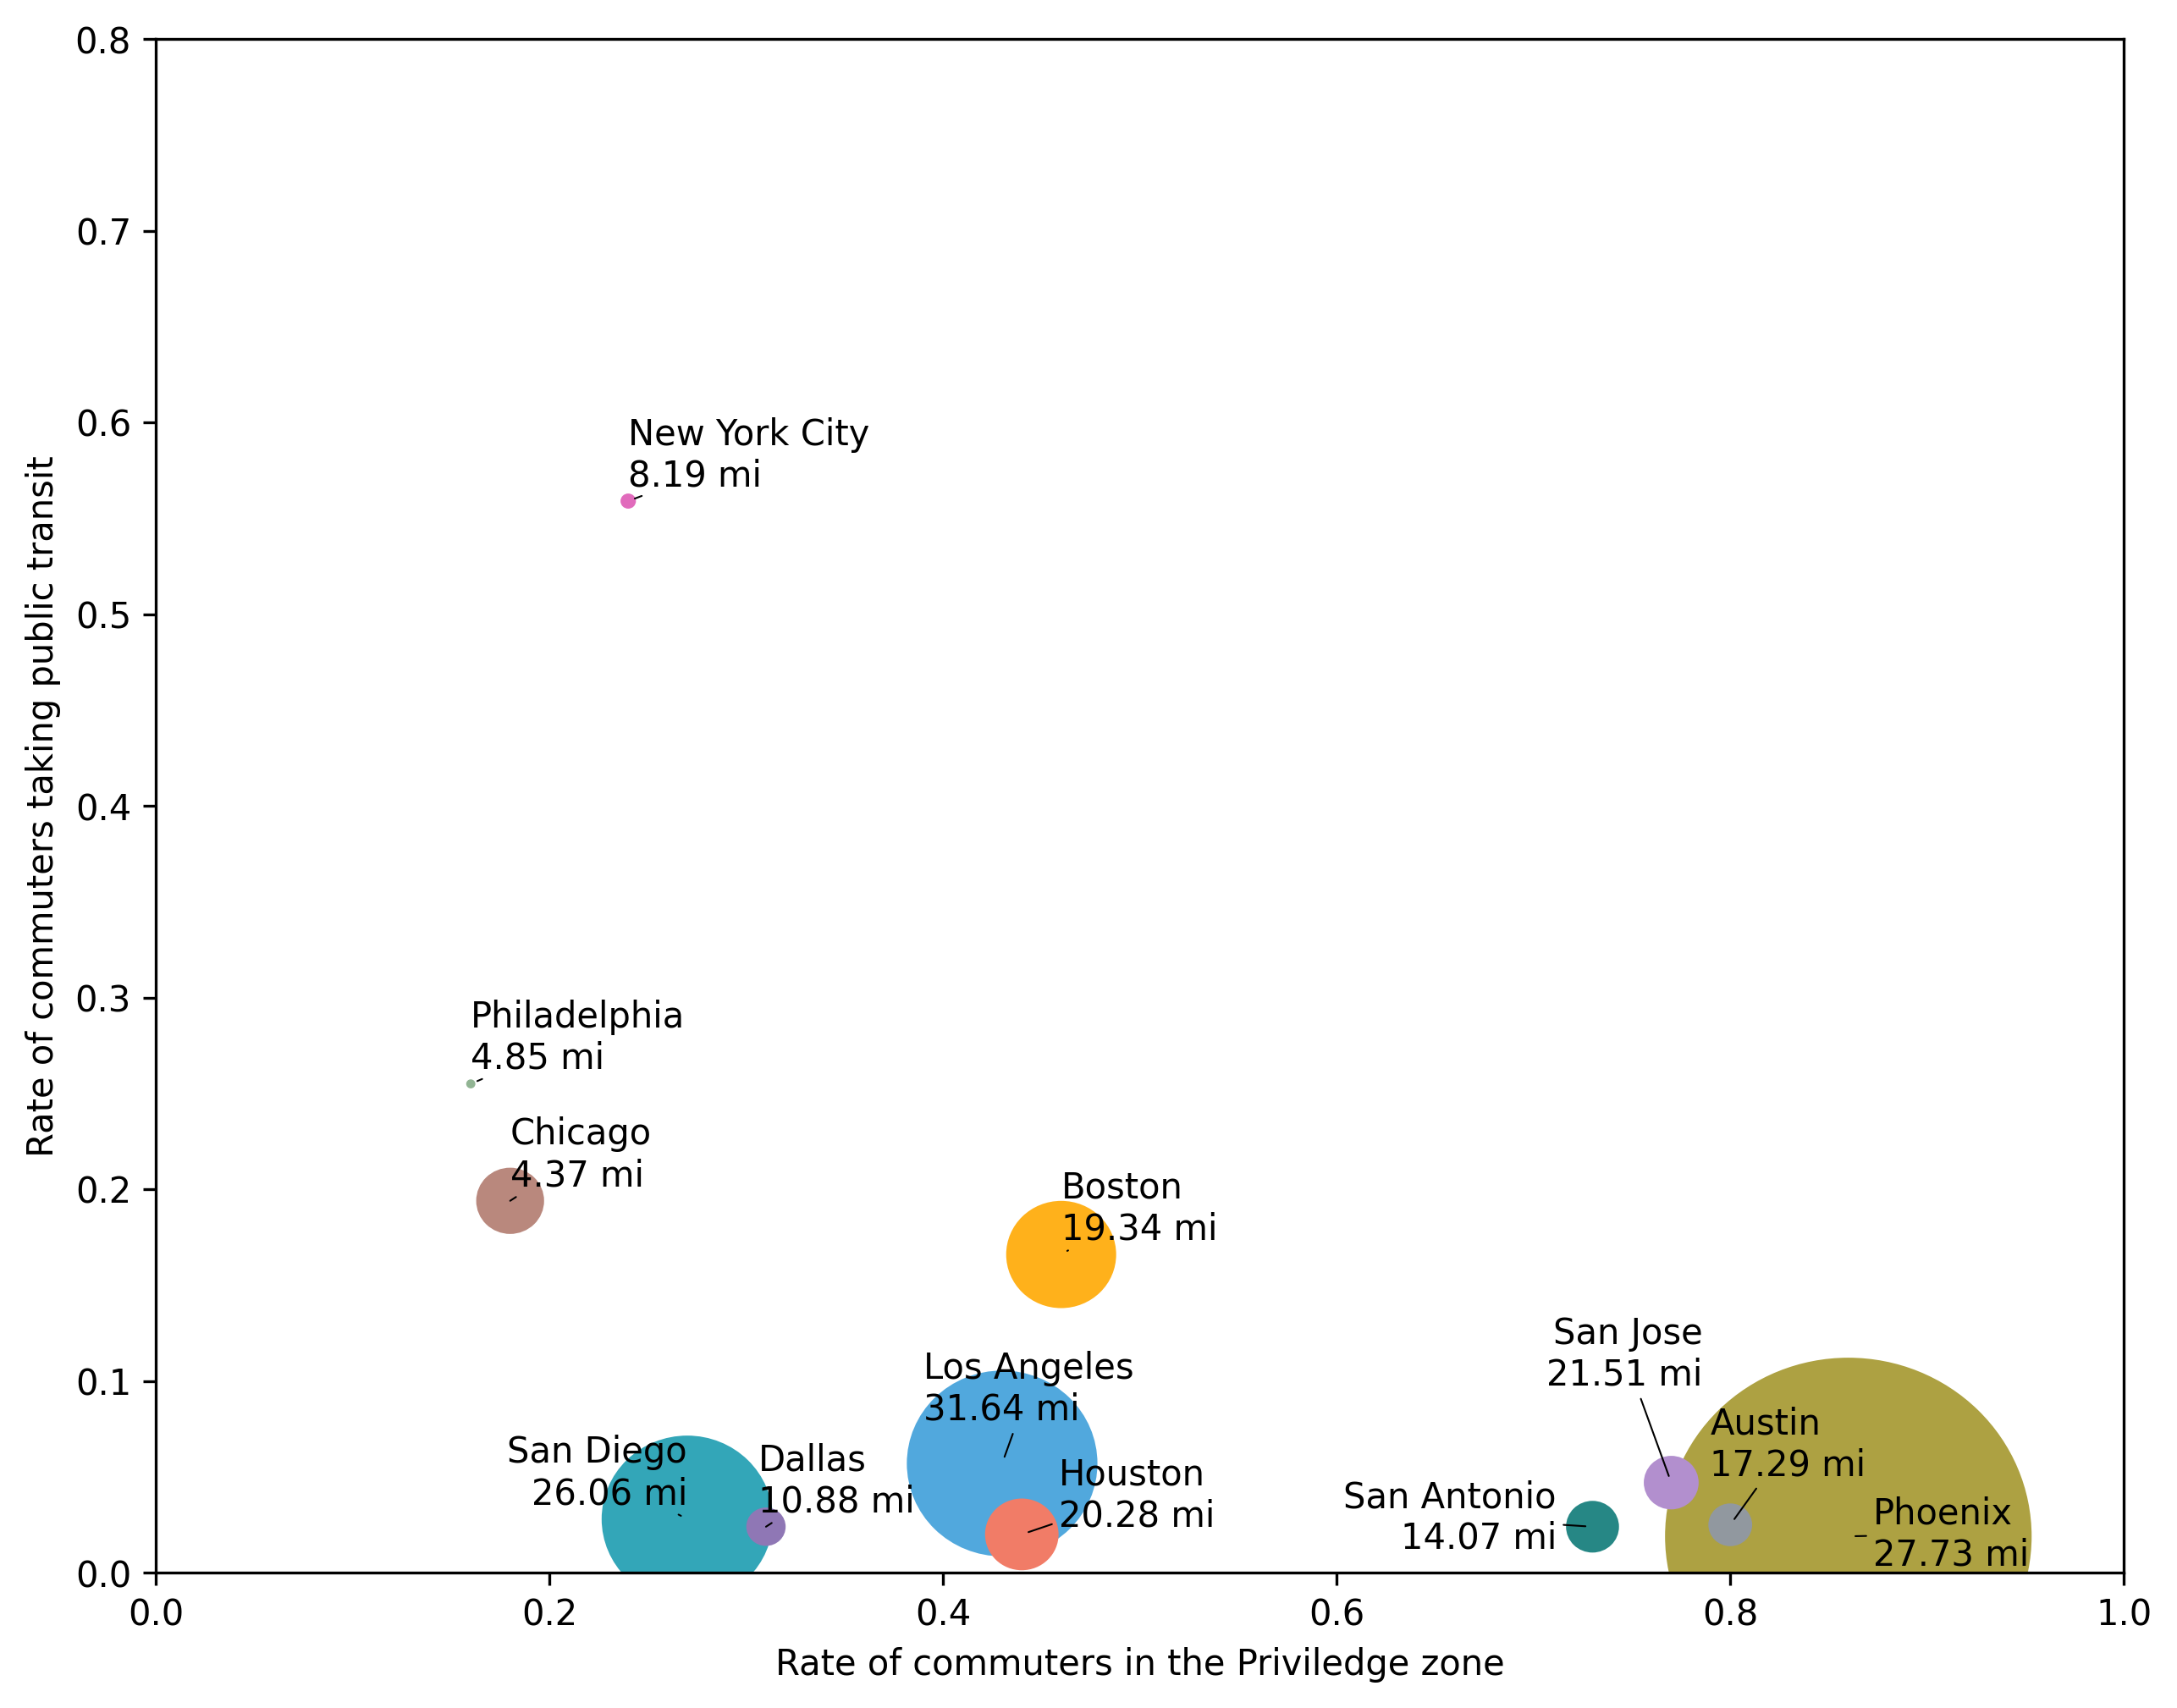

In [33]:
from adjustText import adjust_text

colors = ['#E16BBC','#51A8DD','#B9887D','#F17C67','#FFB11B','#ADA142',
          '#91B493','#268785','#33A6B8','#8F77B5','#b28FCE','#91989F']

fig, ax = plt.subplots(figsize=(10,8),dpi=300)

i = 0
for x, y, r in zip(list(privilegeCommutersRate.values()), list(publictransit.values()),
                       list(size.values())):
    circle = plt.Circle((x, y), r/100000, color=colors[i])
    i += 1
    ax.add_patch(circle)
    
ax.set_ylabel('Rate of commuters taking public transit')
ax.set_xlabel('Rate of commuters in the Priviledge zone')
# for i, txt in enumerate(list(privilege.keys())):
#     ax.annotate(txt, (list(privilege.values())[i], list(publictransit.values())[i]))

texts = []
i = 0
for x, y, s in zip(list(privilegeCommutersRate.values()), 
                   list(publictransit.values()),
                   list(privilegeCommutersRate.keys())):
    texts.append(plt.text(x, y, s+'\n'+str(round(list(privilegeZoneLength.values())[i],2))+' mi'))
    i += 1
plt.ylim([0, 0.8])
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
# plt.show()
plt.savefig('public transit - priviledge rate - size.png')

In [34]:
scaler = MinMaxScaler()
sizevalues = scaler.fit_transform(np.array(list(size.values())).reshape(-1,1))

In [35]:
fitmodel = sm.OLS(sizevalues,np.array(list(privilegeCommutersRate.values())).reshape(-1,1)).fit()
fitmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.540
Model:                            OLS   Adj. R-squared (uncentered):              0.498
Method:                 Least Squares   F-statistic:                              12.89
Date:                Mon, 25 Apr 2022   Prob (F-statistic):                     0.00424
Time:                        19:20:55   Log-Likelihood:                        -0.47017
No. Observations:                  12   AIC:                                      2.940
Df Residuals:                      11   BIC:                                      3.425
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5133      0.143      3.591      0.004       0.199       0.828
==============================================================================
Omnibus:                        1.828   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.401   Jarque-Bera (JB):                1.075
Skew:                           0.710   Prob(JB):                        0.584
Kurtosis:                       2.635   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

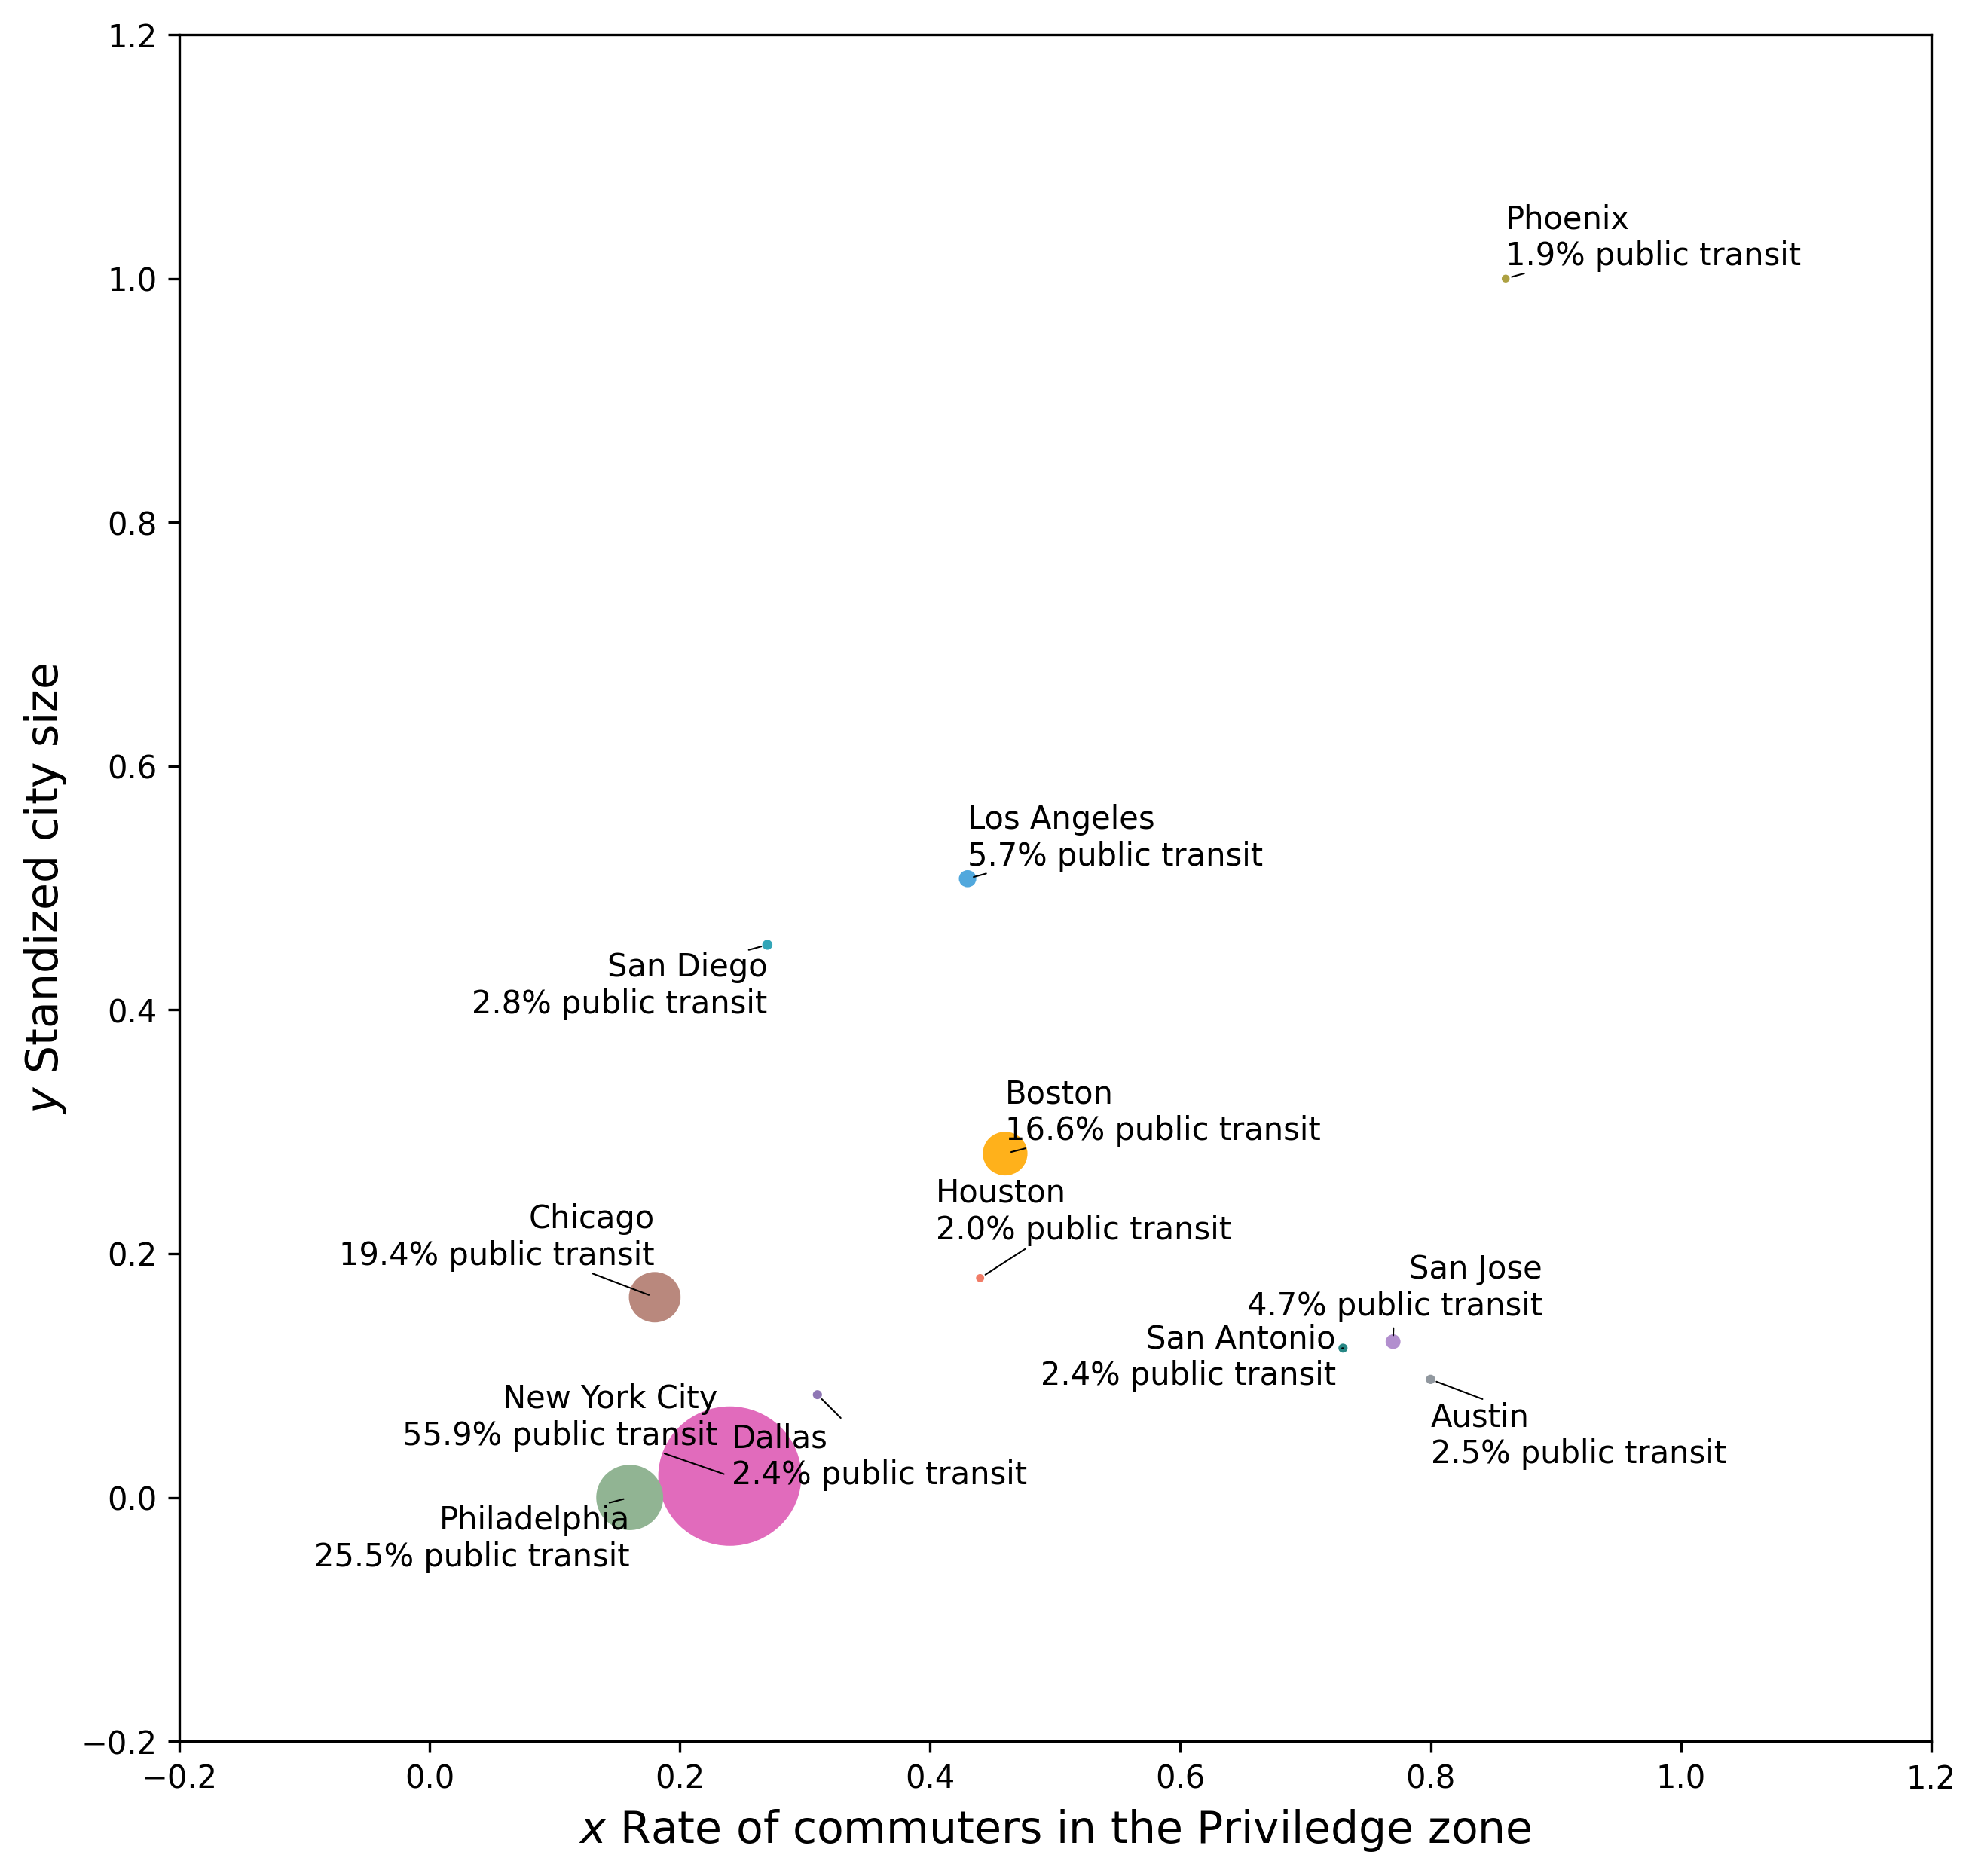

In [36]:
from adjustText import adjust_text

colors = ['#E16BBC','#51A8DD','#B9887D','#F17C67','#FFB11B','#ADA142',
          '#91B493','#268785','#33A6B8','#8F77B5','#b28FCE','#91989F']

fig, ax = plt.subplots(figsize=(10,10),dpi=300)

i = 0
for x, y, r in zip(list(privilegeCommutersRate.values()), sizevalues,
                       list(publictransit.values())):
    circle = plt.Circle((x, y), r/10, color=colors[i])
    i += 1
    ax.add_patch(circle)
    
ax.set_xlabel('$x$ Rate of commuters in the Priviledge zone',fontsize=14)
ax.set_ylabel('$y$ Standized city size',fontsize=14)

# for i, txt in enumerate(list(privilege.keys())):
#     ax.annotate(txt, (list(privilege.values())[i], list(publictransit.values())[i]))

texts = []
i = 0
for x, y, s in zip(list(privilegeCommutersRate.values()), 
                   sizevalues,
                   list(publictransit.keys())):
    texts.append(plt.text(x, y, s+'\n'+str(round(list(publictransit.values())[i]*100,2))+'% public transit'))
    i += 1
plt.xlim([-0.2, 1.2])
plt.ylim([-0.2, 1.2])
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
m = fitmodel.params[0]
# plt.axline(xy1=(0, 0), slope=m, label=f'$y = 0.51x$')
# plt.legend()
plt.savefig('img/public transit - priviledge rate - size.png')

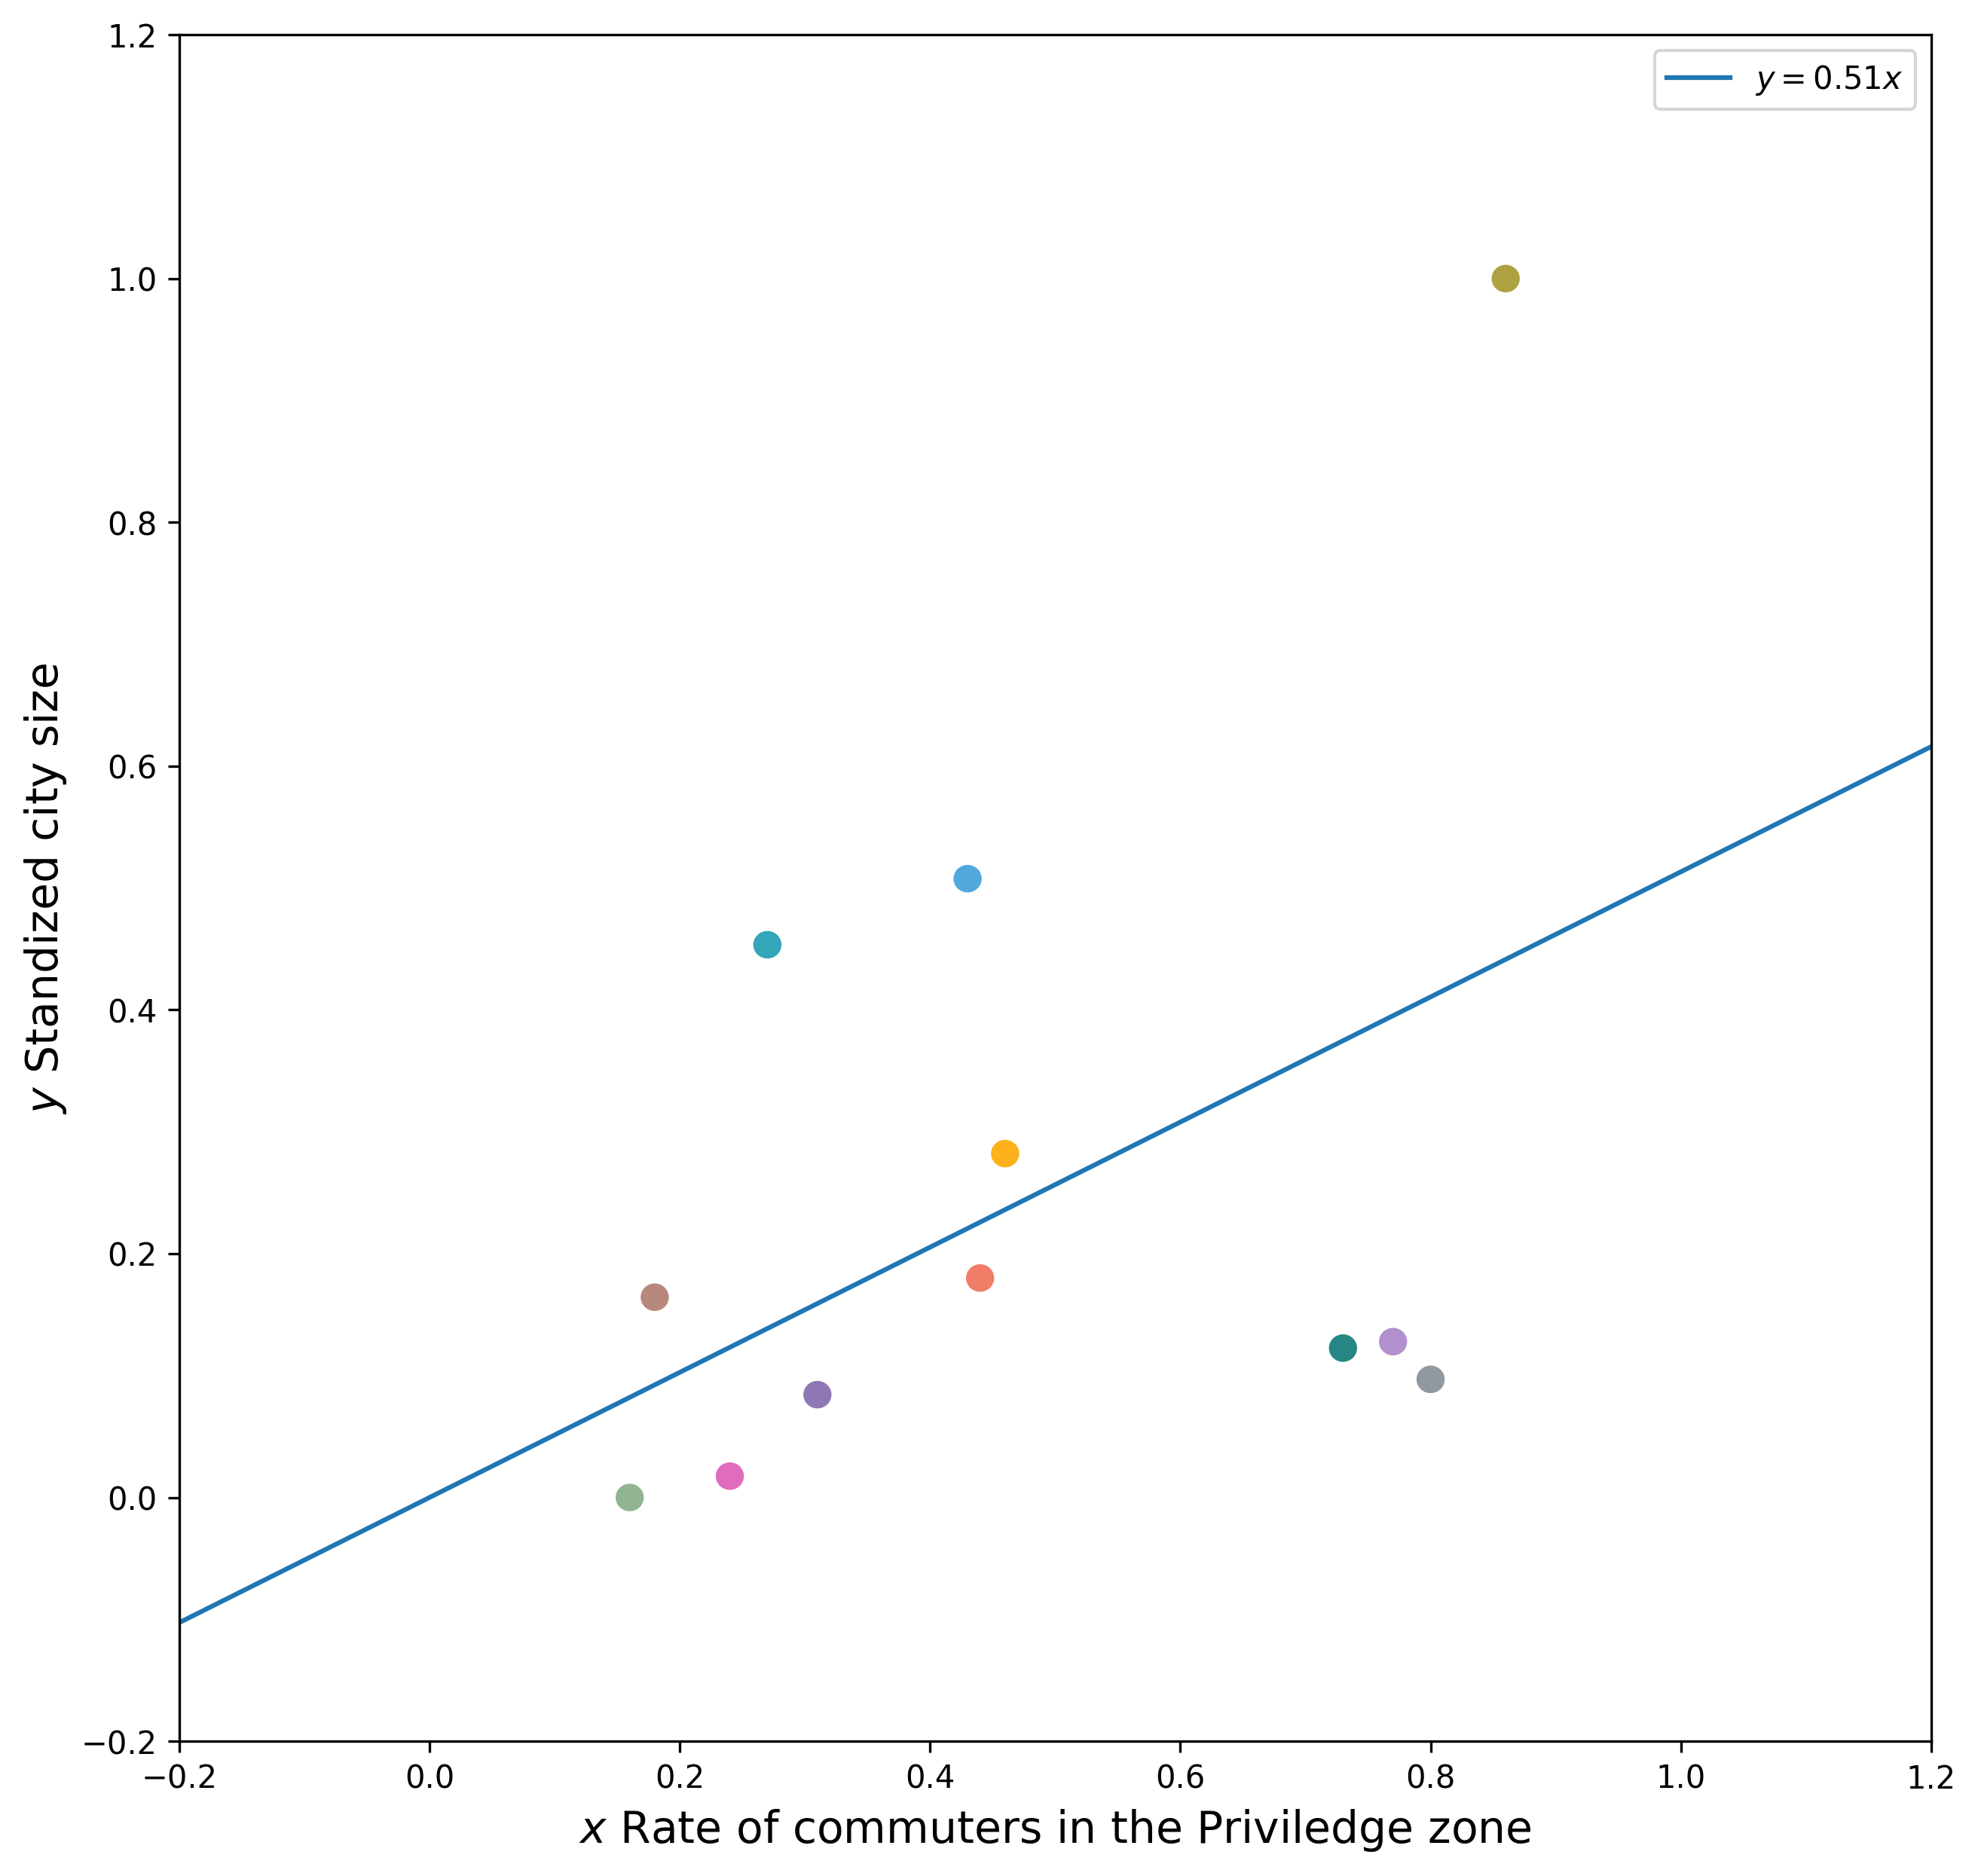

In [37]:
from adjustText import adjust_text

colors = ['#E16BBC','#51A8DD','#B9887D','#F17C67','#FFB11B','#ADA142',
          '#91B493','#268785','#33A6B8','#8F77B5','#b28FCE','#91989F']

fig, ax = plt.subplots(figsize=(10,10),dpi=300)

i = 0
for x, y, r in zip(list(privilegeCommutersRate.values()), sizevalues,
                       list(publictransit.values())):
    circle = plt.Circle((x, y), 0.01, color=colors[i])
    i += 1
    ax.add_patch(circle)
    
ax.set_xlabel('$x$ Rate of commuters in the Priviledge zone',fontsize=14)
ax.set_ylabel('$y$ Standized city size',fontsize=14)


plt.xlim([-0.2, 1.2])
plt.ylim([-0.2, 1.2])
m = fitmodel.params[0]
plt.axline(xy1=(0, 0), slope=m, label=f'$y = 0.51x$')
plt.legend()
plt.savefig('priviledge rate - size.png')

In [125]:
def privilegeEffect(privilege_zone,curve1,curve3,df):
    ind = 0
    SE03_total = df['SE03flow'].sum()
    totalarea = 0
    for dist,fd in curve1:
        if ind+1 < len(curve1):
            # current dist is not it the privilege 
            # area of the triangle after the first intersection
            if dist < privilege_zone[0] and curve1[ind+1][1] >= privilege_zone[0]:
                gap = curve3[ind+1][1] - curve1[ind+1][1]
                commuter = df.loc[df['distance'].between(privilege_zone[0],curve3[ind+1][0],inclusive=True)]['SE03flow'].sum()/SE03_total
                area = gap*commuter*0.5
                totalarea += area
                
            # both current and next dist lies within the privilege zone
            elif dist >= privilege_zone[0] and curve1[ind+1][1] <= privilege_zone[1]:
                # need fd gap from current and next dist to calculate area
                gap1 = curve3[ind][1] - fd
                gap2 = curve3[ind+1][1] - curve1[ind+1][1]
                # curve3[i+1][0] is the next distance value
                # include left exclude right
                commuter = df.loc[df['distance'].between(dist,curve3[ind+1][0]-1e-99,inclusive=True)]['SE03flow'].sum()/SE03_total
                area = (gap1+gap2)*commuter*0.5
                totalarea += area
            # only current dist lies within the privilege zone, the next dist is out of it
            elif dist >= privilege_zone[0] and curve1[ind+1][1] > privilege_zone[1]:
                # calculate the triangle area
                gap = curve3[ind][1] - fd
                commuter = df.loc[df['distance'].between(dist,curve3[ind+1][0],inclusive=True)]['SE03flow'].sum()/SE03_total
                area = gap*commuter*0.5
                totalarea += area

            else:
                pass
        ind += 1
    return totalarea

In [126]:
### privilege effect degree (gap between two curves integrated by %% of privilege commuters in this zone)
privilegeEffectValue = {}
for city,state, counties in cities:
    if city in citiesList:
        curve1 = list(zip([float(i) for i in Distfd1[city].keys()],Distfd1[city].values()))
        curve3 = list(zip([float(i) for i in Distfd3[city].keys()],Distfd3[city].values()))
        length,privilege_zone = the_longest_privilege_zone(curve1,curve3)
        df = pd.read_parquet(f'data/income_{city}.parquet')
        df['distance'] = df['distance']/1.6
        startpoint = startPoints[city]/1.6
        # include 95% of distance 
        startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
        afterendpointPercentage = 0.05 - startpointPercentage
        if afterendpointPercentage > 0:
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
        else:
            endPoint = df.distance.max()
        df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
        totalarea = privilegeEffect(privilege_zone,curve1,curve3,df)
        print(city,totalarea)
        privilegeEffectValue[city] = totalarea

New York City 0.007556893584139341
Los Angeles 0.0956032118485222
Chicago 0.008745880194479588
Houston 0.053409229649523535
Boston 0.05489125328266796
Phoenix 0.11136561588029469
Philadelphia 0.008697628188920073
San Antonio 0.049530127308442425
San Diego 0.012019166414483194
Dallas 0.020731558760765215
San Jose 0.0634111105506841
Austin 0.09398814288906807


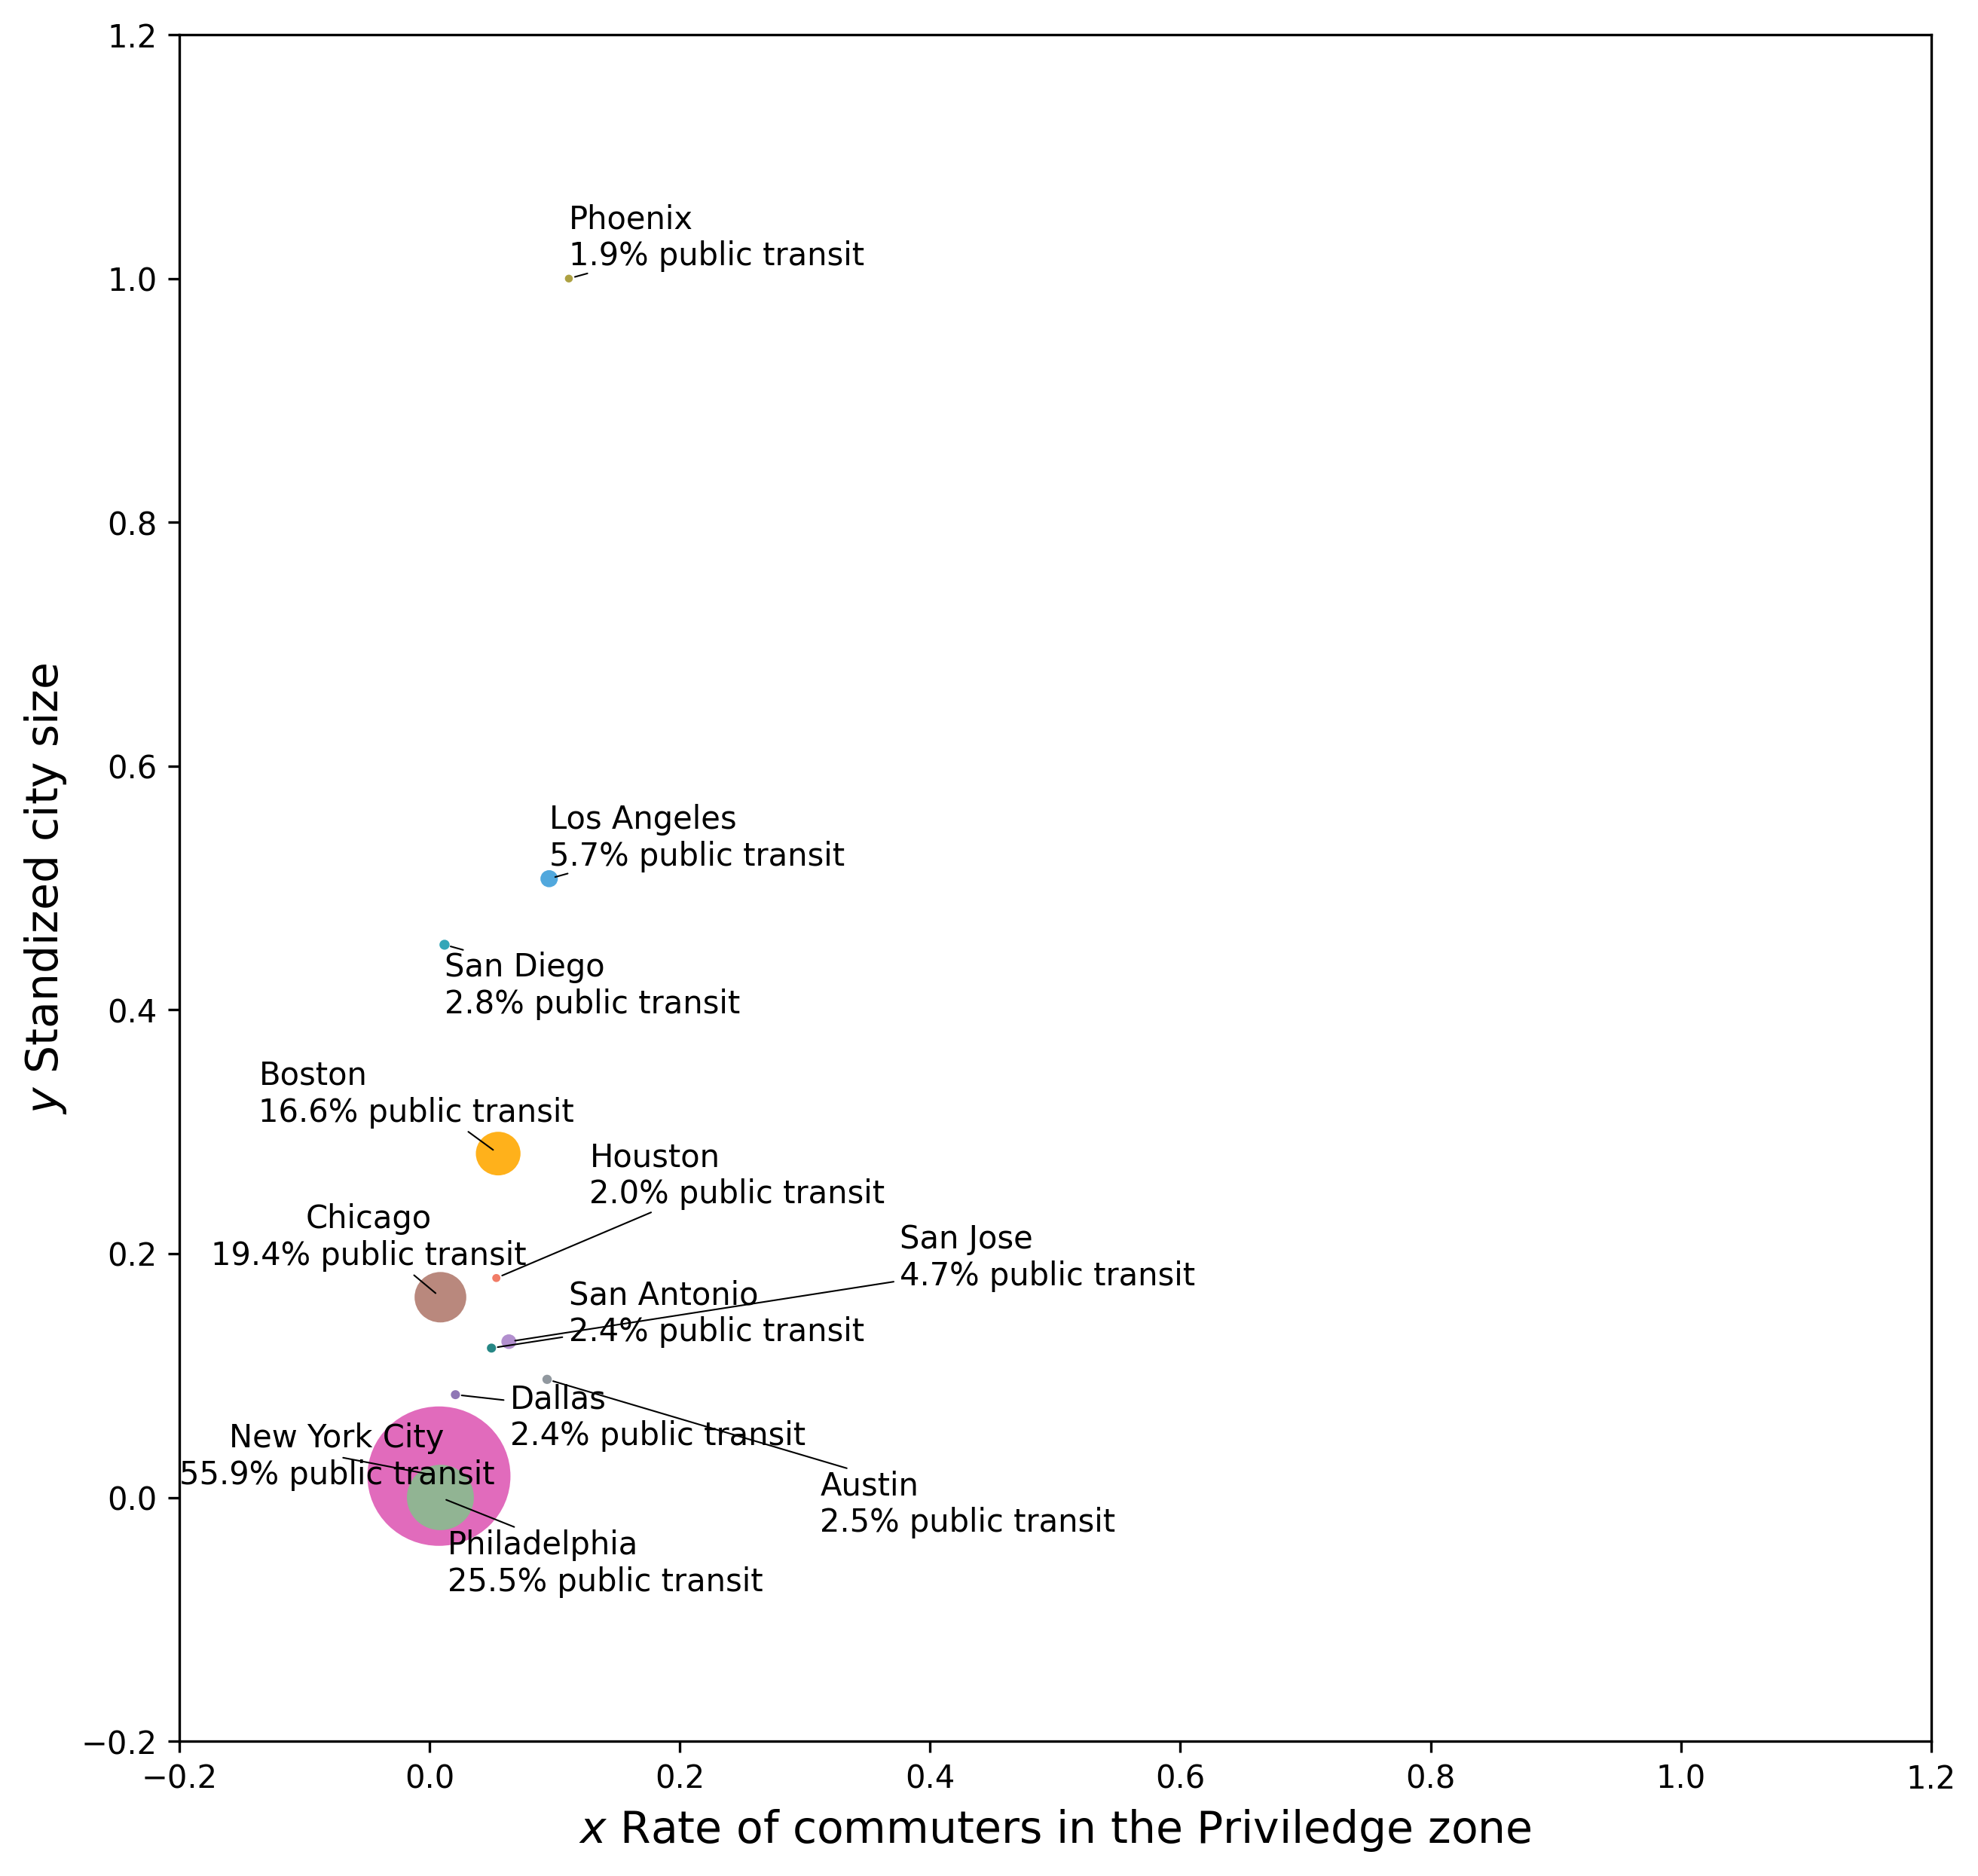

In [127]:
from adjustText import adjust_text

colors = ['#E16BBC','#51A8DD','#B9887D','#F17C67','#FFB11B','#ADA142',
          '#91B493','#268785','#33A6B8','#8F77B5','#b28FCE','#91989F']

fig, ax = plt.subplots(figsize=(10,10),dpi=300)

i = 0
for x, y, r in zip(list(privilegeEffectValue.values()), sizevalues,
                       list(publictransit.values())):
    circle = plt.Circle((x, y), r/10, color=colors[i])
    i += 1
    ax.add_patch(circle)
    
ax.set_xlabel('$x$ Rate of commuters in the Priviledge zone',fontsize=14)
ax.set_ylabel('$y$ Standized city size',fontsize=14)

# for i, txt in enumerate(list(privilege.keys())):
#     ax.annotate(txt, (list(privilege.values())[i], list(publictransit.values())[i]))

texts = []
i = 0
for x, y, s in zip(list(privilegeEffectValue.values()), 
                   sizevalues,
                   list(publictransit.keys())):
    texts.append(plt.text(x, y, s+'\n'+str(round(list(publictransit.values())[i]*100,2))+'% public transit'))
    i += 1
plt.ylim([-0.2, 1.2])
plt.xlim([-0.2, 1.2])
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
m = fitmodel.params[0]
# plt.axline(xy1=(0, 0), slope=m, label=f'$y = 0.51x$')
# plt.legend()
plt.savefig('img/public transit - priviledge effect - size.png')

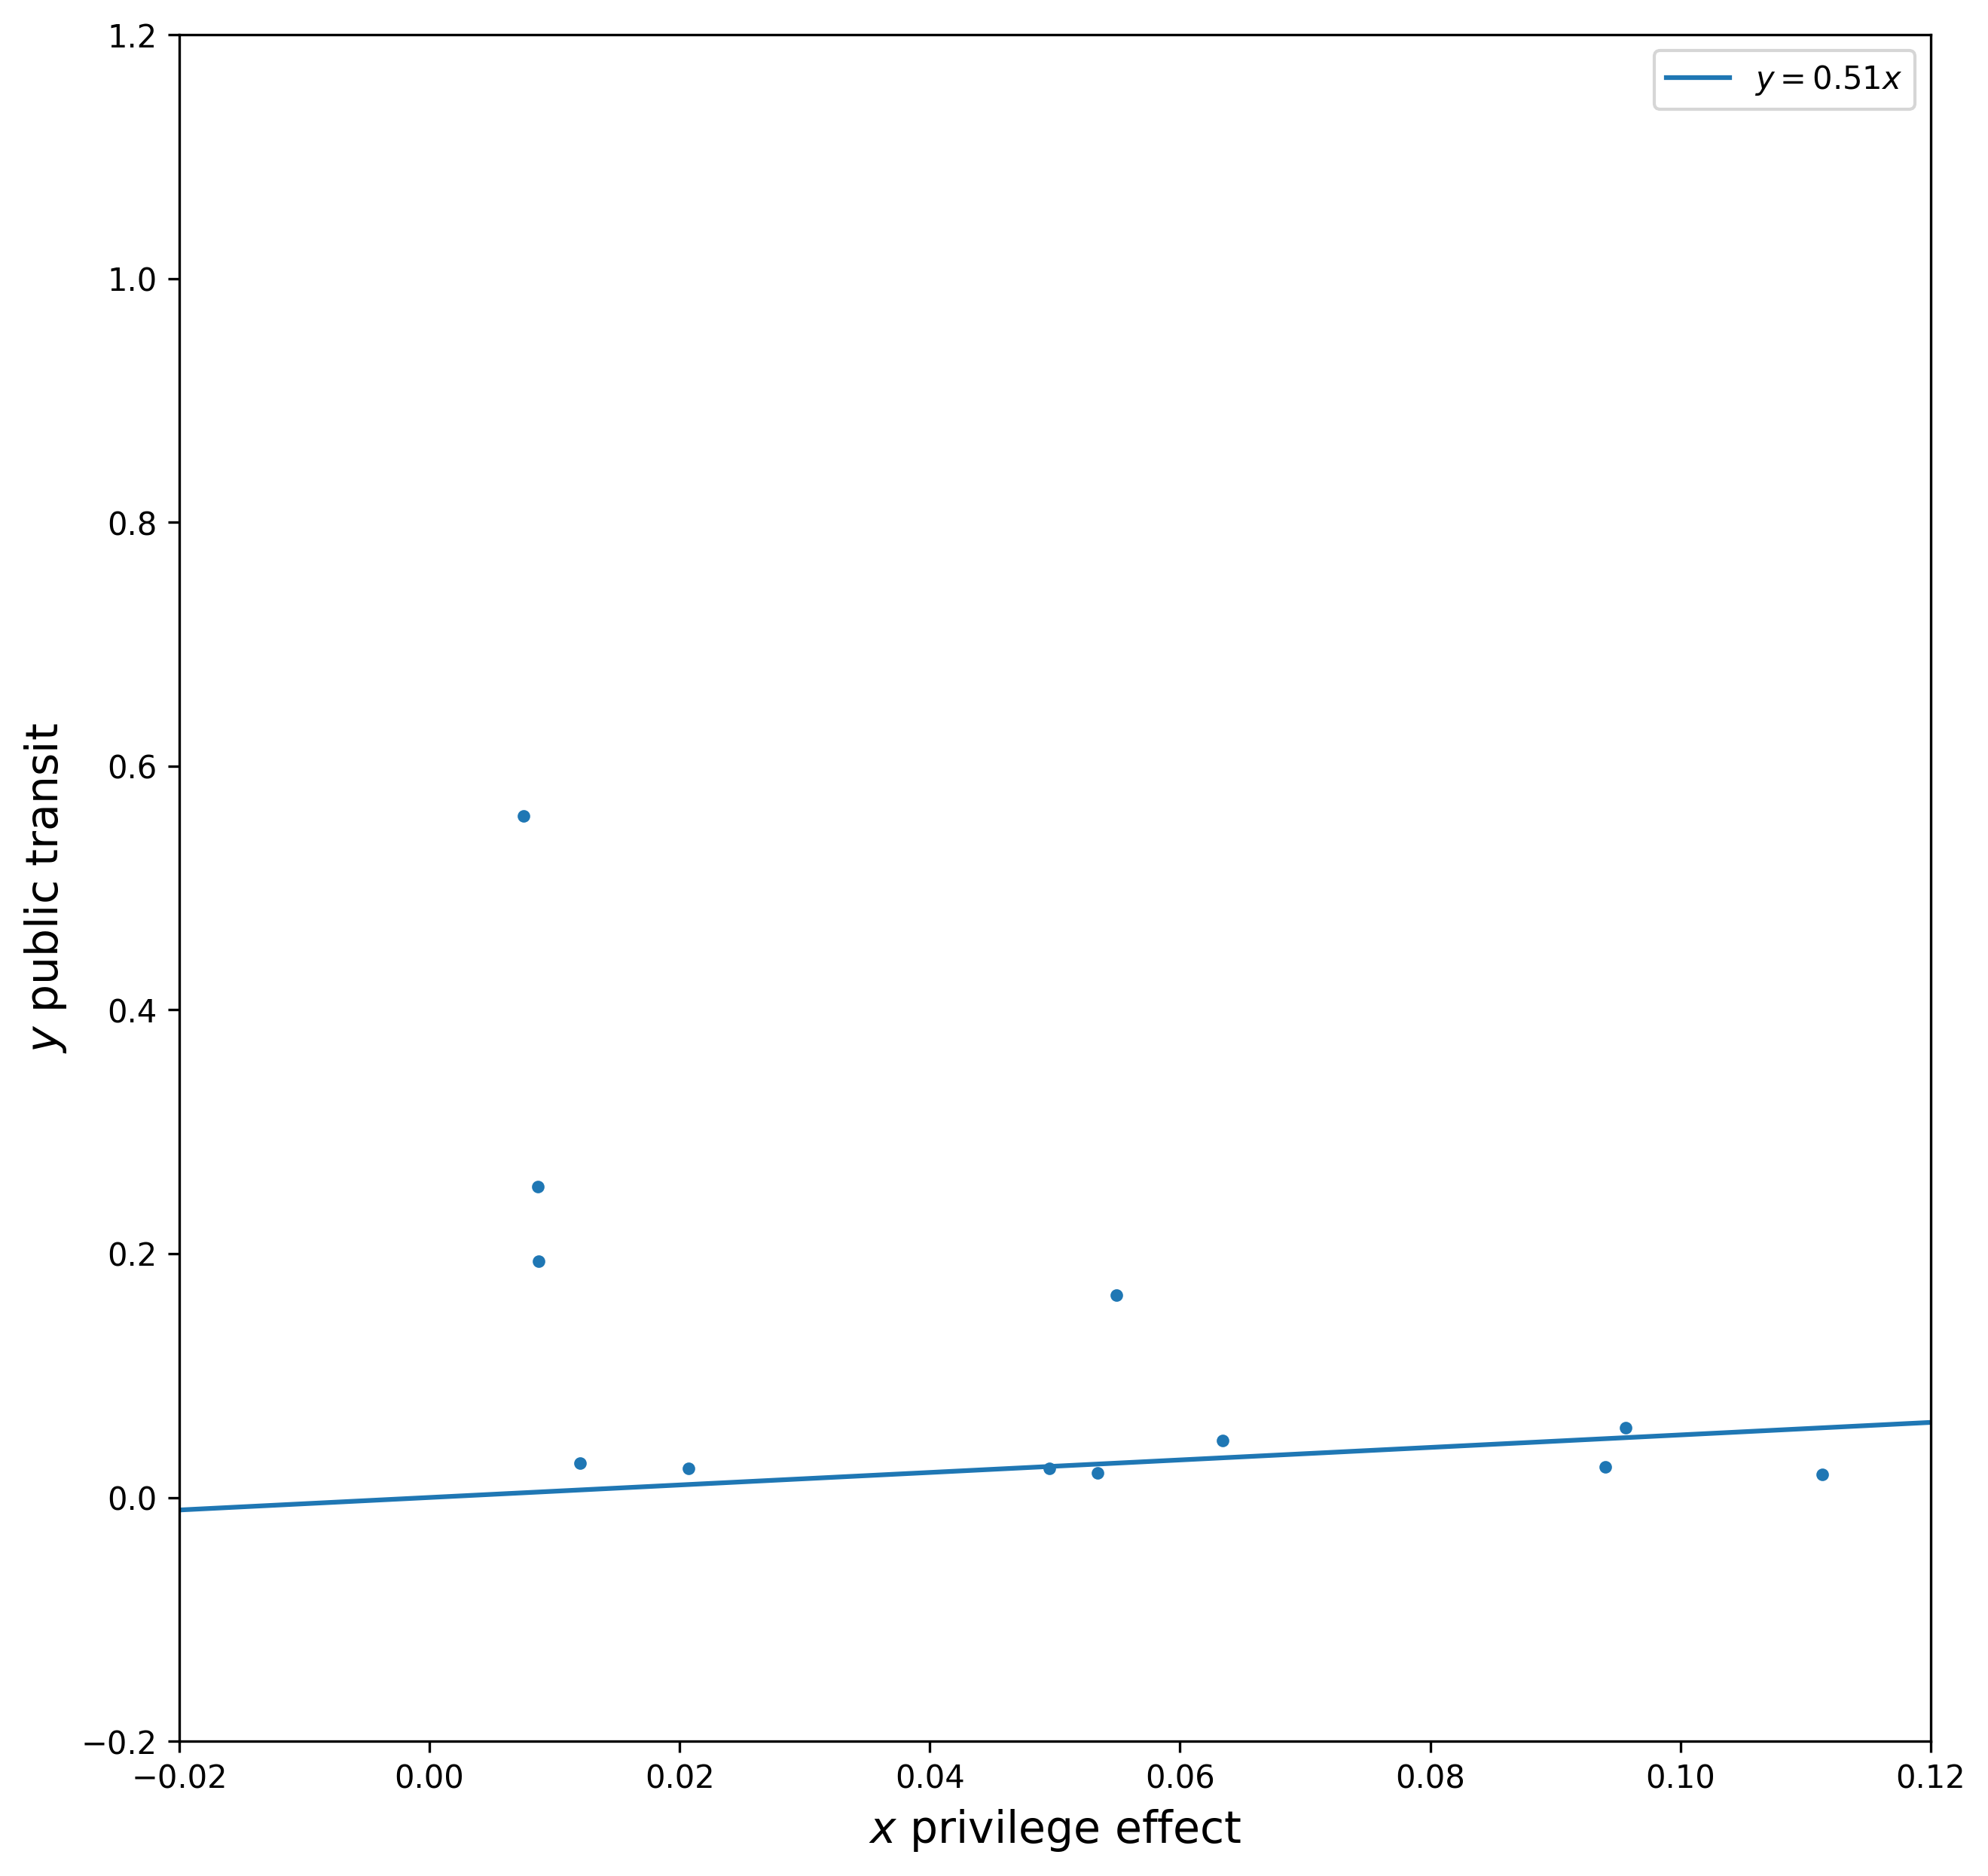

In [128]:
from adjustText import adjust_text

colors = ['#E16BBC','#51A8DD','#B9887D','#F17C67','#FFB11B','#ADA142',
          '#91B493','#268785','#33A6B8','#8F77B5','#b28FCE','#91989F']

fig, ax = plt.subplots(figsize=(10,10),dpi=300)

i = 0

plt.plot(privilegeEffectValue.values(),publictransit.values(),'.')
    
ax.set_xlabel('$x$ privilege effect',fontsize=14)
ax.set_ylabel('$y$ public transit',fontsize=14)


plt.xlim([-0.02, 0.12])
plt.ylim([-0.2, 1.2])
m = fitmodel.params[0]
plt.axline(xy1=(0, 0), slope=m, label=f'$y = 0.51x$')
plt.legend()
plt.savefig('img/priviledge effect - public transit.png')

In [136]:
# privilege strength is how privilege are commuters in the privilege zone
# in other words, how easier
# average gap in the whole privilege zone
# gap integrated by distance then divided by the total distance of the privilege zone
def privilegeStrength(privilege_zone,curve1,curve3,df):
    ind = 0
    SE03_total = df['SE03flow'].sum()
    totalarea = 0
    for dist,fd in curve1:
        if ind+1 < len(curve1):
            # current dist is not it the privilege 
            # area of the triangle after the first intersection
            if dist < privilege_zone[0] and curve1[ind+1][1] >= privilege_zone[0]:
                gap = curve3[ind+1][1] - curve1[ind+1][1]
                binDist = curve3[ind+1][0] - priviledge_zone[0]
                area = gap*binDist*0.5
                totalarea += area
#                 print(ind,area)
            # both current and next dist lies within the privilege zone
            elif dist >= privilege_zone[0] and curve1[ind+1][1] <= privilege_zone[1]:
                # need fd gap from current and next dist to calculate area
                gap1 = curve3[ind][1] - fd
                gap2 = curve3[ind+1][1] - curve1[ind+1][1]
                # curve3[i+1][0] is the next distance value
                # include left exclude right
                binDist = curve3[ind+1][0] - curve3[ind][0]
                area = (gap1+gap2)*binDist*0.5
                totalarea += area
#                 print(ind,area)
            # only current dist lies within the privilege zone, the next dist is out of it
            elif dist < privilege_zone[1] and curve1[ind+1][1] > privilege_zone[1]:
                # calculate the triangle area
                gap = curve3[ind][1] - fd
                binDist = priviledge_zone[1] - curve3[ind][0]
                area = gap*binDist*0.5
                totalarea += area
#                 print(ind,area)
            
            else:
                pass
        
        ind += 1
#         print(totalarea)
    return totalarea/(priviledge_zone[1]-priviledge_zone[0])

In [137]:
### privilege effect degree (gap between two curves integrated by %% of privilege commuters in this zone)
privilegeStrengthValue = {}
for city,state, counties in cities:
    if city in citiesList:
        curve1 = list(zip([float(i) for i in Distfd1[city].keys()],Distfd1[city].values()))
        curve3 = list(zip([float(i) for i in Distfd3[city].keys()],Distfd3[city].values()))
        length,privilege_zone = the_longest_privilege_zone(curve1,curve3)
        df = pd.read_parquet(f'data/income_{city}.parquet')
        df['distance'] = df['distance']/1.6
        startpoint = startPoints[city]/1.6
        # include 95% of distance 
        startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
        afterendpointPercentage = 0.05 - startpointPercentage
        if afterendpointPercentage > 0:
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
        else:
            endPoint = df.distance.max()
        df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
        totalarea = privilegeStrength(privilege_zone,curve1,curve3,df)
        print(city,totalarea)
        privilegeStrengthValue[city] = totalarea

New York City 0.028302691940092956
Los Angeles 0.5940883424703821
Chicago 0.0005649491965218817
Houston 0.1496741904197363
Boston 0.15763647007133033
Phoenix 0.16729233619330233
Philadelphia 0.017525747142044665
San Antonio 0.050991238439702775
San Diego 0.07505834995755585
Dallas 0.03803839968448605
San Jose 0.1478321613421824
Austin 0.1156034459751371


In [123]:
scaler = MinMaxScaler()
normprivilegeStrengthValue = scaler.fit_transform(np.array(list(privilegeStrengthValue.values())).reshape(-1,1))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


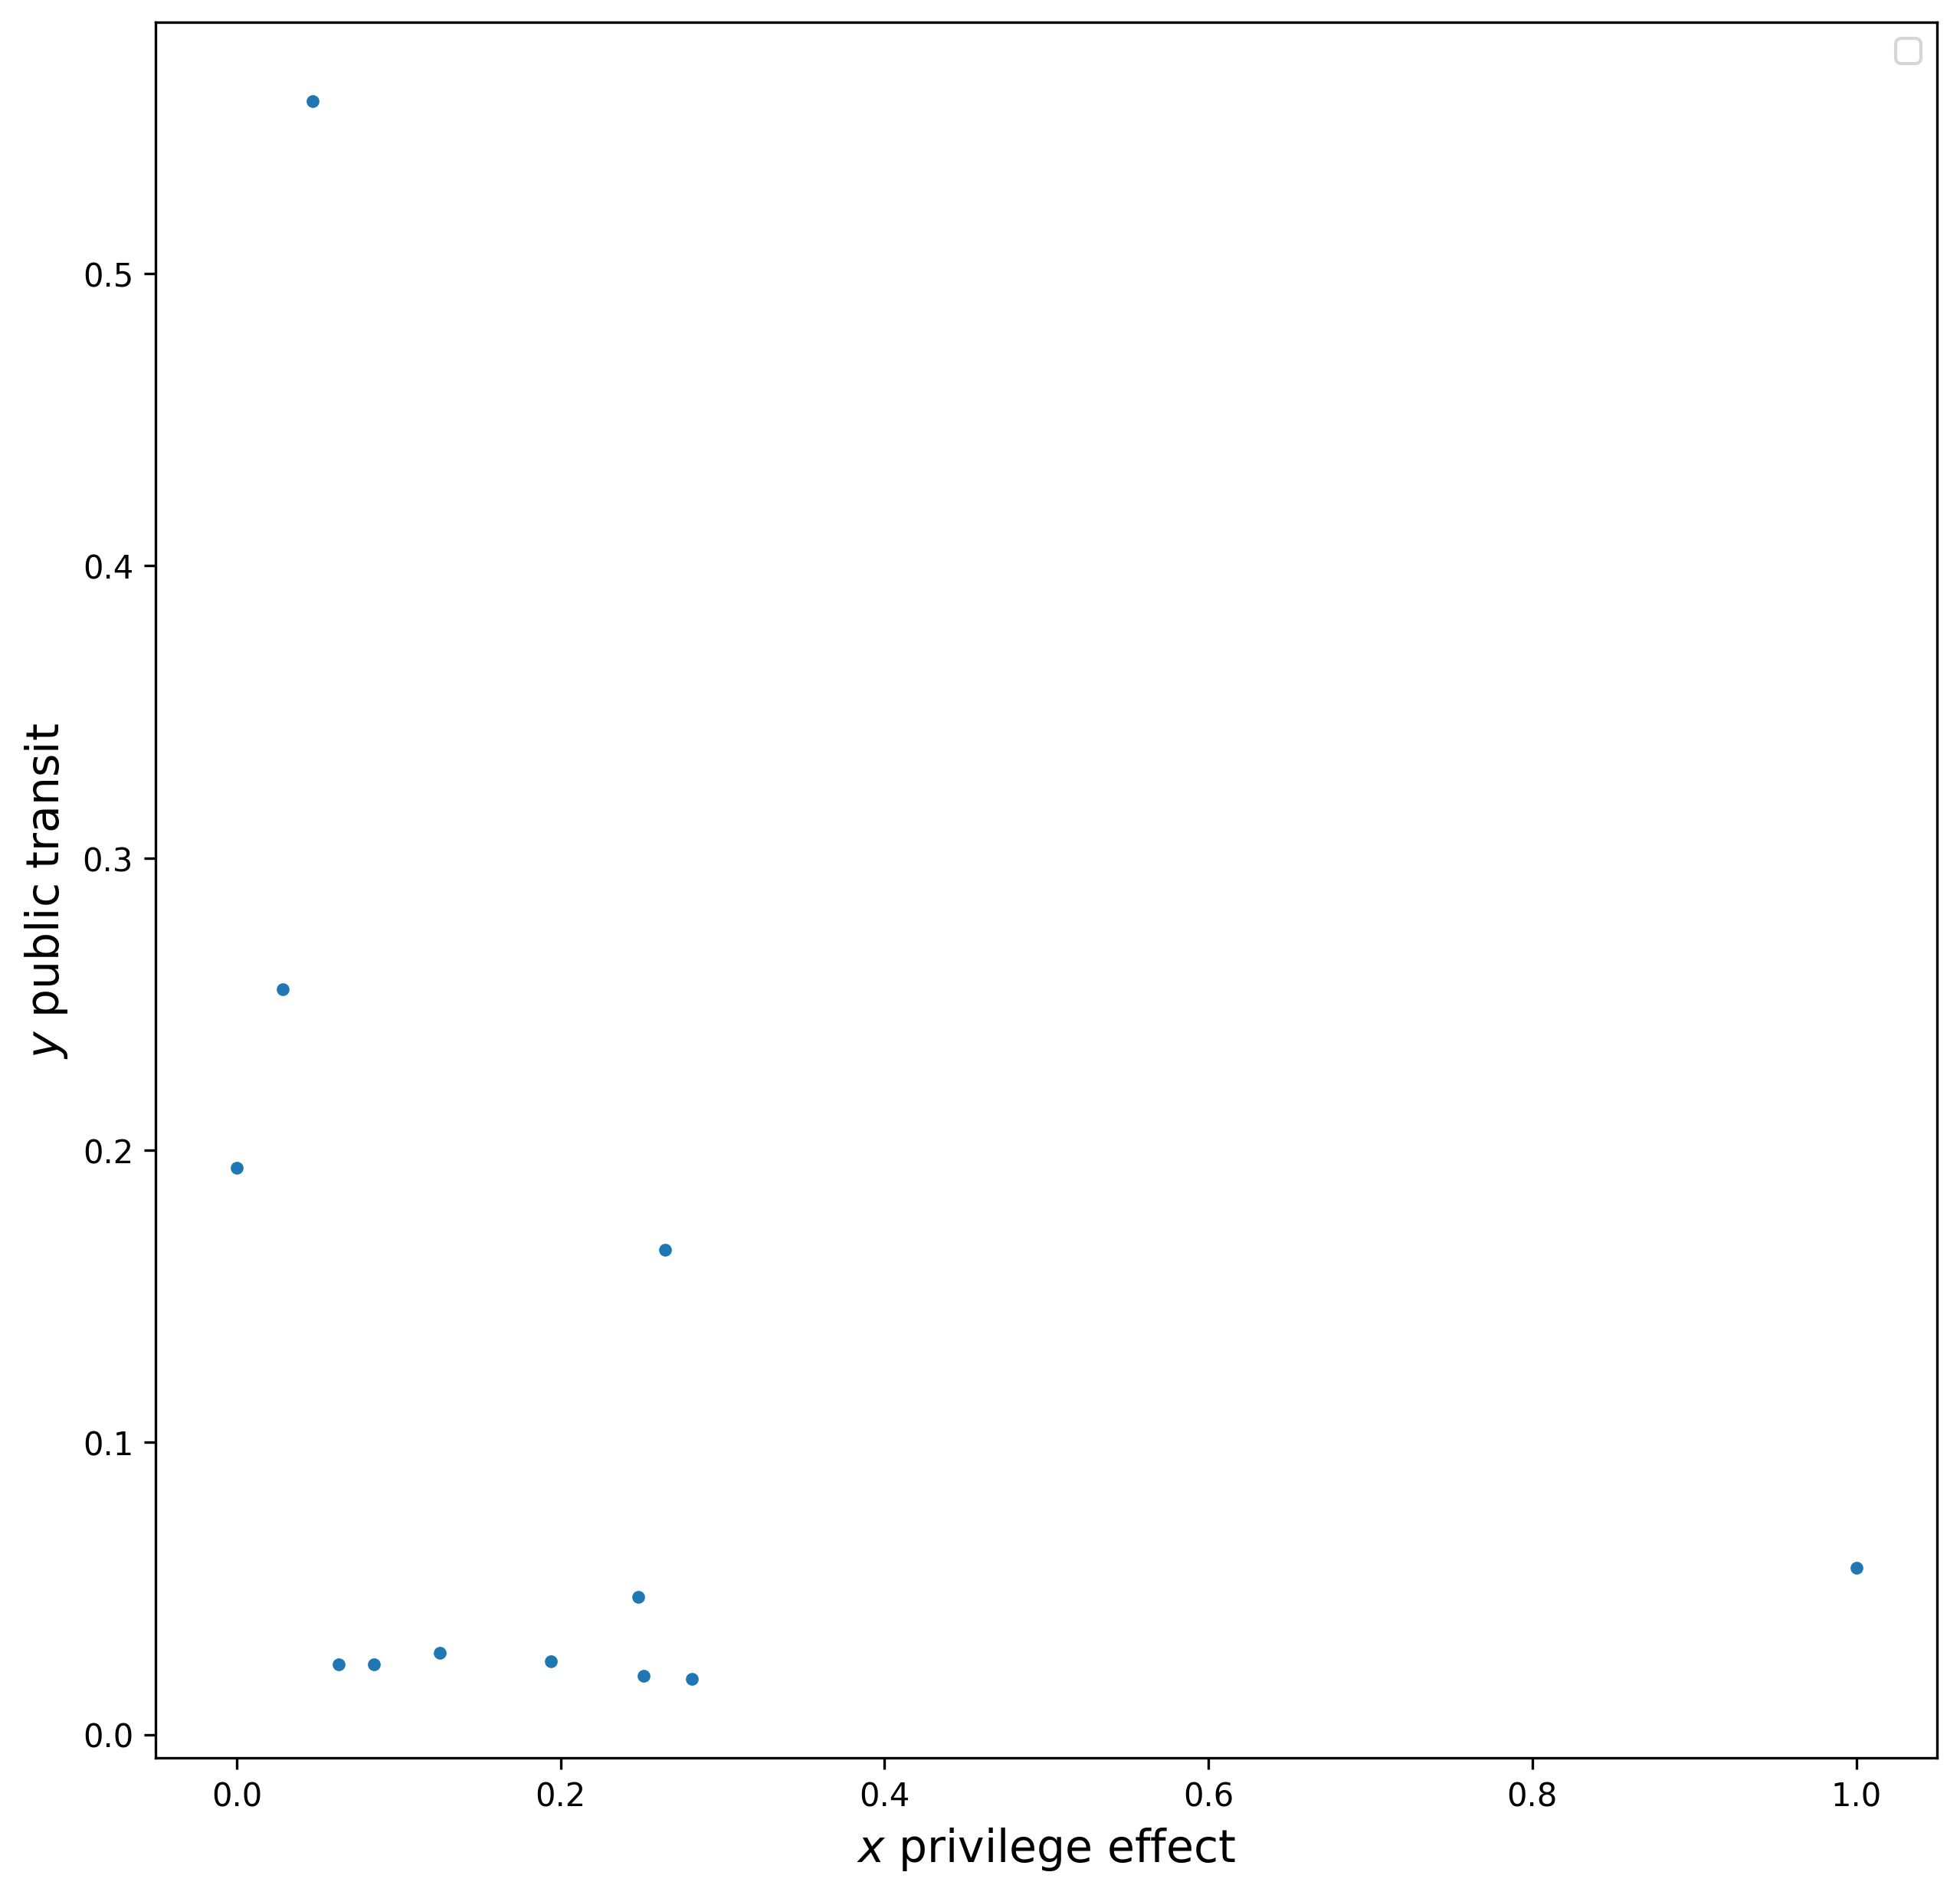

In [124]:
from adjustText import adjust_text

colors = ['#E16BBC','#51A8DD','#B9887D','#F17C67','#FFB11B','#ADA142',
          '#91B493','#268785','#33A6B8','#8F77B5','#b28FCE','#91989F']

fig, ax = plt.subplots(figsize=(10,10),dpi=300)

i = 0

plt.plot(normprivilegeStrengthValue,publictransit.values(),'.')
    
ax.set_xlabel('$x$ privilege effect',fontsize=14)
ax.set_ylabel('$y$ public transit',fontsize=14)


# plt.xlim([-0.02, 0.12])
# plt.ylim([-0.2, 1.2])
m = fitmodel.params[0]
# plt.axline(xy1=(0, 0), slope=m, label=f'$y = 0.51x$')
plt.legend()
plt.savefig('img/priviledge strength - public transit.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


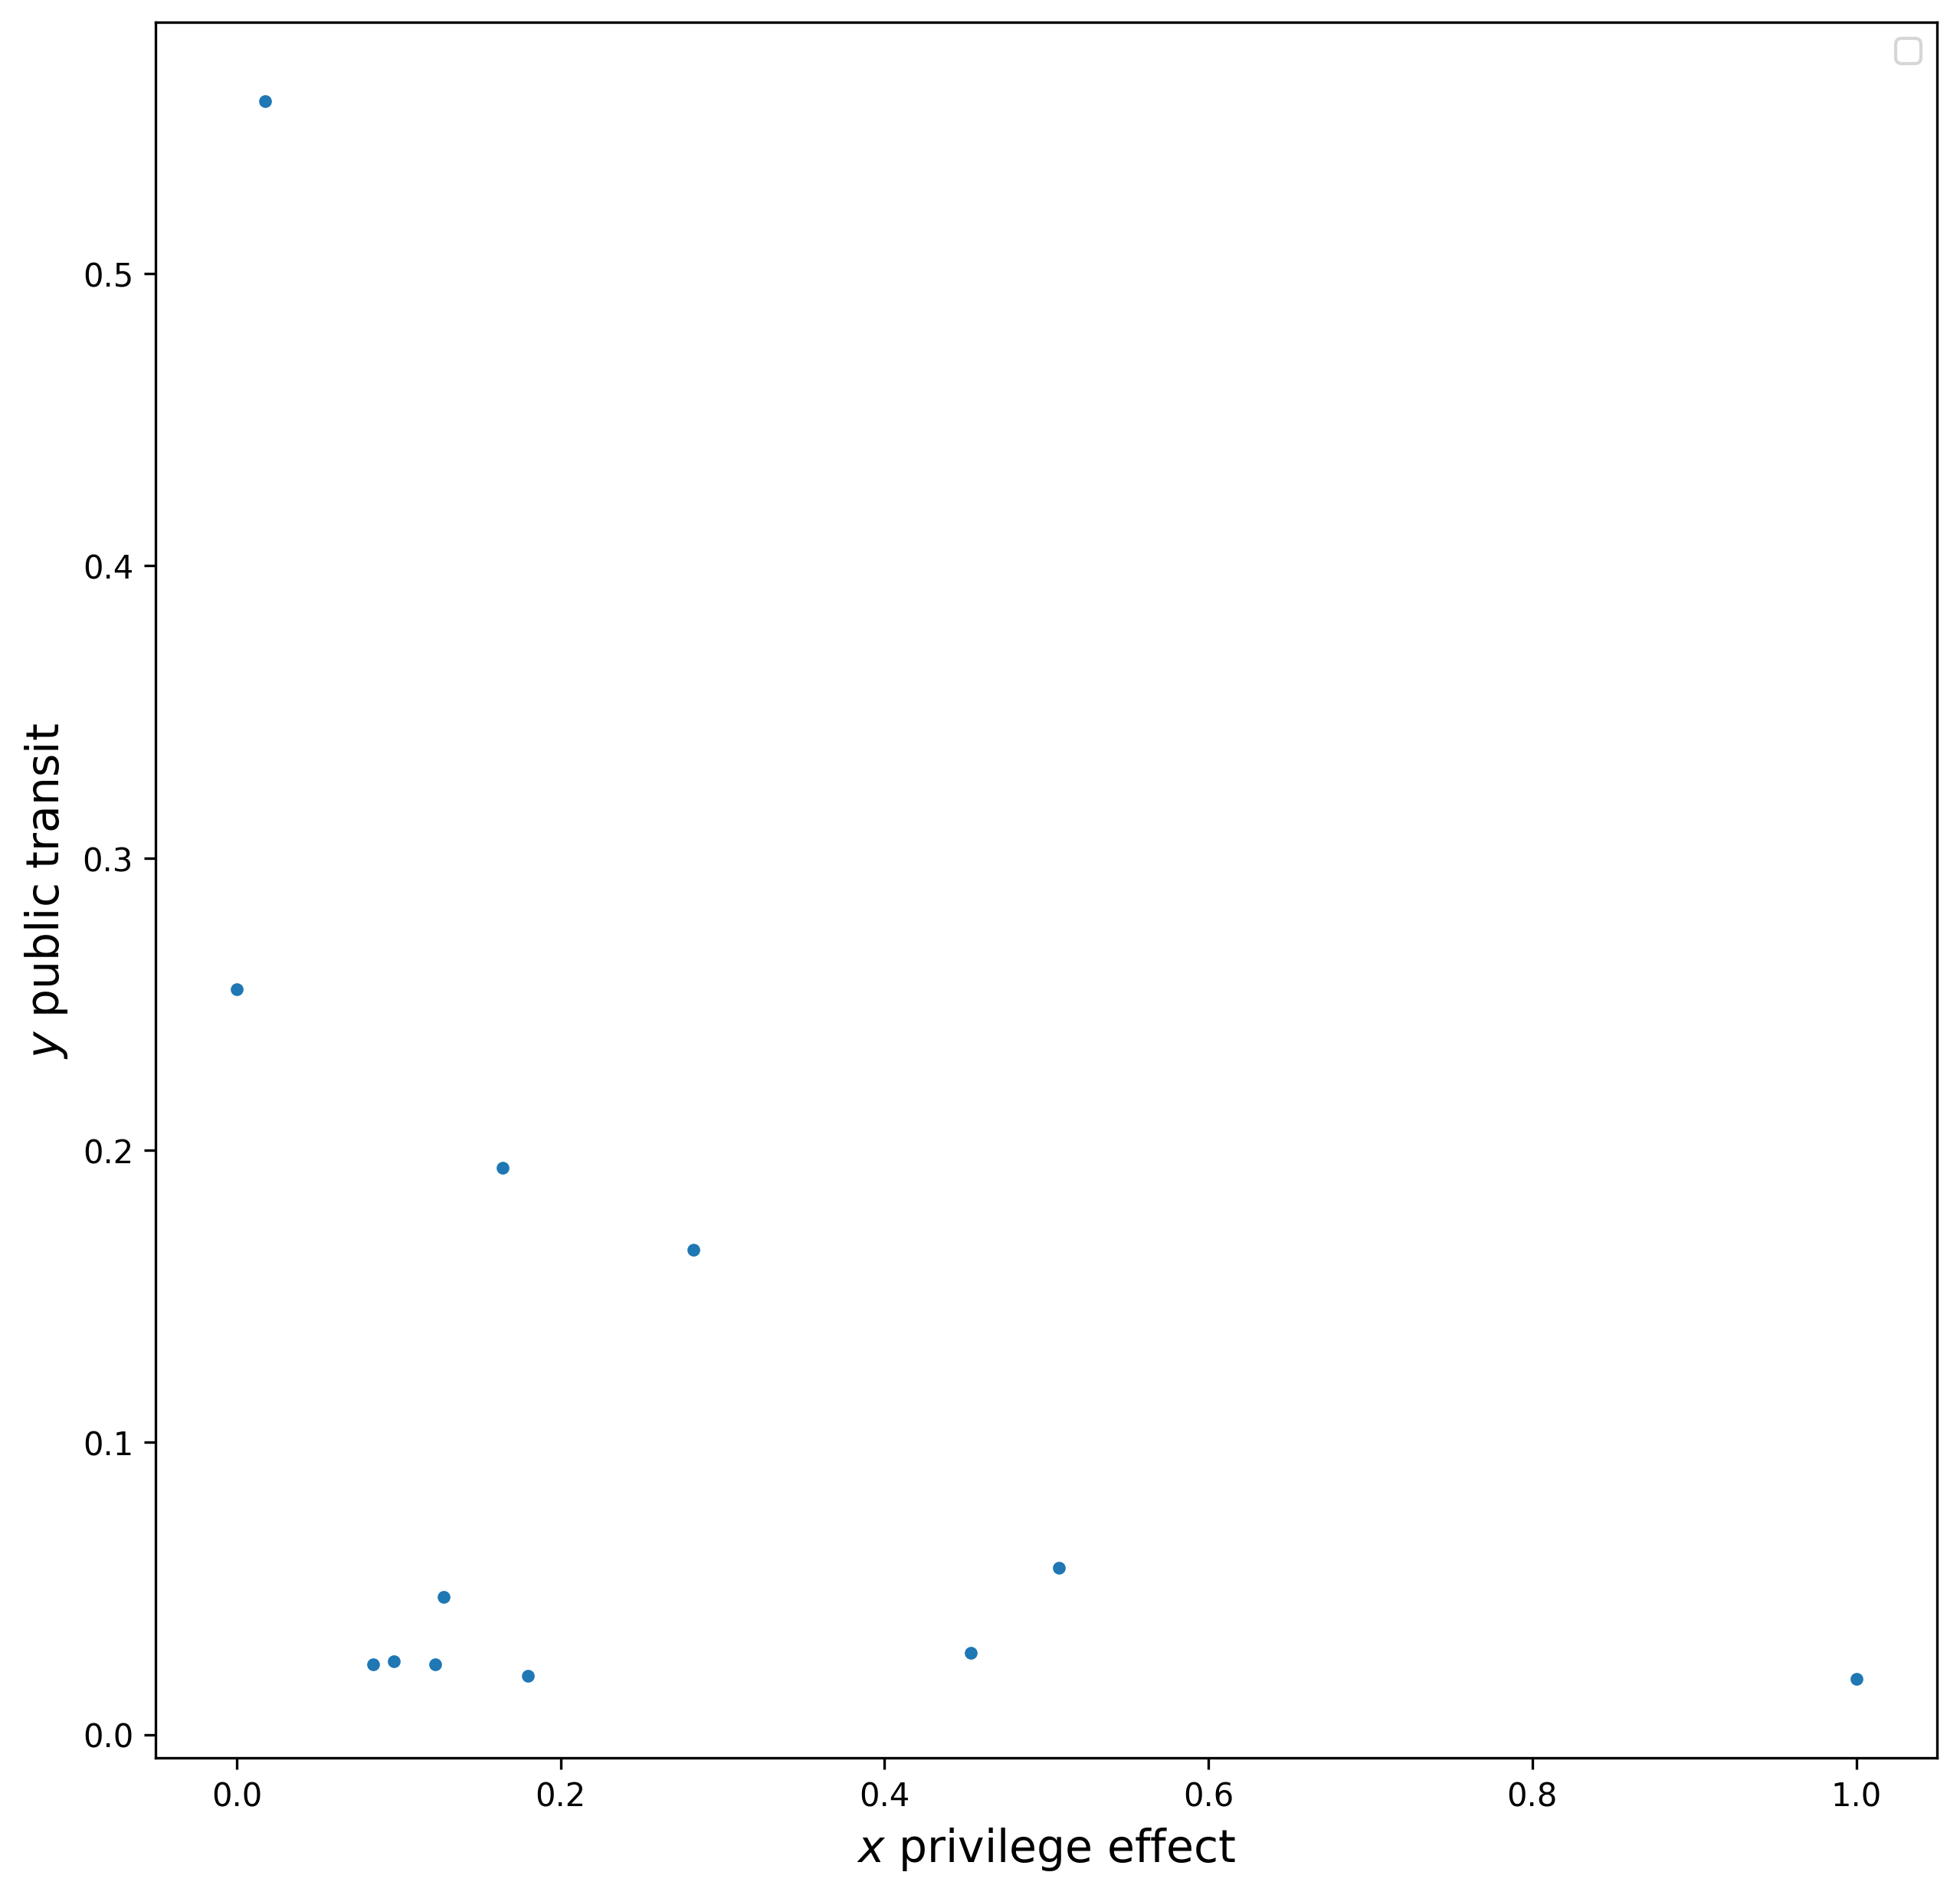

In [138]:
from adjustText import adjust_text

colors = ['#E16BBC','#51A8DD','#B9887D','#F17C67','#FFB11B','#ADA142',
          '#91B493','#268785','#33A6B8','#8F77B5','#b28FCE','#91989F']

fig, ax = plt.subplots(figsize=(10,10),dpi=300)

i = 0

plt.plot(sizevalues,publictransit.values(),'.')
    
ax.set_xlabel('$x$ privilege effect',fontsize=14)
ax.set_ylabel('$y$ public transit',fontsize=14)


# plt.xlim([-0.02, 0.12])
# plt.ylim([-0.2, 1.2])
m = fitmodel.params[0]
# plt.axline(xy1=(0, 0), slope=m, label=f'$y = 0.51x$')
plt.legend()
plt.savefig('img/priviledge strength - size.png')

## Monte Carlo simulation

In [66]:
NUM_POINTS = 20

def generate_random_points(shape):
    minx, miny, maxx, maxy = shape.bounds
    xc = (maxx - minx) * np.random.random(NUM_POINTS) + minx
    yc = (maxy - miny) * np.random.random(NUM_POINTS) + miny

    points = gpd.GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
    filtered_points = points.loc[points.within(shape)]
    points_geo = list(zip(filtered_points.y, filtered_points.x))
    return points_geo
    
def get_avg_point_to_point_distance(shape_a, shape_b):
    points_a = generate_random_points(shape_a)
    points_b = generate_random_points(shape_b)
    common_points = min(len(points_a), len(points_b), 1)
    if common_points == 0:
        return None
    
    points_a_c = points_a[0:common_points]
    points_b_c = points_b[0:common_points]
    distance = haversine_vector(points_a_c, points_b_c, Unit.KILOMETERS)
    mean_distance = statistics.mean(distance)
    return mean_distance


SAMPLES = 20000


def get_avg_distance(gdf):
    output = []
    for i in range(SAMPLES):
        sample = gdf.sample(n = 2)

        shape_a = sample.reset_index().loc[0]["geometry"]
        shape_b = sample.reset_index().loc[1]["geometry"]
        id_a = sample.index[0]
        id_b = sample.index[1]
        avg_distance = get_avg_point_to_point_distance(shape_a, shape_b)
        if avg_distance is not None:
            output.append({'from': id_a, 'to': id_b, 'p2p_avg_distance': avg_distance})
    
    pdf = pd.DataFrame(output)
    return pdf

In [67]:
output = {}
for city, state, conties in cities:
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    training_set = build_training_set(city_network, 'S000')
    nodes = city_network.nodes
    avg_distance = get_avg_distance(nodes)
    
    merged = pd.merge(training_set, avg_distance,  how='inner', left_on=['origin','destination'], right_on = ['from','to'])
    merged_filtered = merged
    merged_filtered['delta'] = np.abs(merged_filtered.distance - merged_filtered.p2p_avg_distance)
    quantiles = merged_filtered.delta.quantile([.5, .6, .7, .8, .9, 0.95, 0.99])
    output[city] = quantiles.to_dict()
    error = merged_filtered.delta.mean() 
    print(f"{city}: {error}")

New York City: 0.23318465336358488
Los Angeles: 0.5880542251098596
Chicago: 0.47264545956451637
Houston: 0.8544507944813855
Boston: 0.7216409787770274
Phoenix: 1.0696908912977126
Philadelphia: 0.35620353722320486
San Antonio: 0.9753960859438853
San Diego: 0.9532767780401463
Dallas: 0.729267064123792
San Jose: 0.7819044087441388
Austin: 1.136174461579971


In [ ]:
pd.DataFrame(output)

,New York City,Los Angeles,Chicago,Houston,Boston,Phoenix,Philadelphia,San Antonio,San Diego,Dallas,San Jose,Austin
0.50,0.176530,0.373929,0.349259,0.626014,0.483576,0.589840,0.277706,0.689228,0.563316,0.565688,0.485094,0.751230
0.60,0.220729,0.473481,0.443118,0.797668,0.639243,0.751285,0.347748,0.872422,0.722217,0.708454,0.615565,0.975461
0.70,0.277682,0.596798,0.564801,1.009724,0.837312,0.961928,0.431537,1.096358,0.909662,0.885414,0.781659,1.256536
0.80,0.351193,0.771752,0.736969,1.300103,1.133779,1.257603,0.543070,1.424256,1.229035,1.131133,1.013852,1.681846
0.90,0.485592,1.097315,1.021622,1.814740,1.670841,1.906330,0.729216,2.080797,1.932760,1.543676,1.496020,2.560253
0.95,0.640003,1.555651,1.317518,2.404259,2.250880,3.011811,0.933643,3.029391,3.037446,1.980435,2.248784,3.560927
0.99,1.091991,3.864622,2.119622,4.155098,3.541665,11.672539,1.558372,5.184831,7.811290,3.028761,5.252093,6.235240
